In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import numpy.matlib
from PIL import Image

Mounted at /content/drive


# Нужные функции

In [ ]:
def preparePicture(img, scaling = 4):
  origSize_X = len(img)
  origSize_Y = len(img[0])
  newSize_X = int(origSize_X * scaling)
  newSize_Y = int(origSize_Y * scaling)
  tempImg = np.zeros((newSize_X, newSize_Y))
  if scaling < 1:
    for i in range(0, newSize_X):
      for j in range(0, newSize_Y):
        tempImg[i, j] = img[int(i/scaling)][int(j/scaling)]
  elif scaling >= 1:
    for i in range(0, origSize_X):
      for j in range(0, origSize_Y):
        tempImg[(i * scaling) : (i * scaling + scaling),
                (j * scaling) : (j * scaling + scaling)] = img[i][j]
  return tempImg.astype(np.uint8)

In [ ]:
def getDifferenceFromImages(img1, img2, limitedSubtract = False):
  if limitedSubtract:
    temp = img1.astype(np.int32) - img2.astype(np.int32)
    temp = np.where(temp < 0, 0, temp)
  else:
    temp = abs(img1.astype(np.int32) - img2.astype(np.int32))
  return temp.astype(np.uint8)

In [ ]:
def Metrics(origImg, advImg):
  diffBtwArrays = origImg.astype(np.int32) - advImg.astype(np.int32)
  L0 = np.sum(np.where(diffBtwArrays != 0, 1, diffBtwArrays))
  L1 = np.sum(abs(diffBtwArrays))
  L2 = np.sum(diffBtwArrays**2) ** 0.5
  Linf = np.max(abs(diffBtwArrays))

  return L0, L1, L2, Linf

In [ ]:
def getNumOfExamples(arr):
  numExamples = 0
  for i in range(0, len(arr)):
    if arr[i]["info"] == "orig":
      numExamples += 1
  return numExamples

# Фильтры

In [ ]:
def linearFilter(image, m = 3, n = 3):
  M, N = image.shape
  s_m = int((m - 1) / 2)
  s_n = int((n - 1) / 2)
  filteredImage = np.zeros((M, N))
  for i in range(s_m, M - s_m):
    for j in range(s_n, N - s_n):
      filteredImage[i][j] = int(np.sum(image[i - s_m: i + s_m + 1, j - s_n: j + s_n + 1]) / (m * n))
  return filteredImage

In [ ]:
def medianFilter(image, m = 3, n = 3):
  M, N = image.shape
  s_m = int(round((m - 1) / 2))
  s_n = int(round((n - 1) / 2))
  filteredImage = np.zeros((M, N))
  for i in range(s_m, M - s_m):
    for j in range(s_n, N - s_n):
      temp = image[i - s_m: i + s_m + 1, j - s_n: j + s_n + 1].reshape(n * m)
      filteredImage[i][j] = np.median(temp)

  return filteredImage

In [ ]:
def sharpeningFilter(image):
  M, N = image.shape
  mask_a = np.reshape([0, 1, 0, 1, -4, 1, 0, 1, 0], (3, 3))
  mask_b = np.reshape([1, 1, 1, 1, -8, 1, 1, 1, 1], (3, 3))
  mask_d = np.reshape([-1, -1, -1, -1, 8, -1, -1, -1, -1], (3, 3))

  m, n = mask_b.shape
  s_m = int(round((m - 1) / 2))
  s_n = int(round((n - 1) / 2))
  filteredImage = np.zeros((M, N))

  for i in range(s_m, M - s_m):
    for j in range(s_n, N - s_n):
      filteredImage[i][j] = int(np.sum(image[i-s_m:i+s_m+1, j-s_n:j+s_n+1] * mask_b))

  filteredImage = image - filteredImage
  filteredImage = np.where(filteredImage > 255, 255, filteredImage)
  filteredImage = np.where(filteredImage < 0, 0, filteredImage)

  return filteredImage.astype(np.uint8)

In [ ]:
def FourierFrequencyFiltering(image, radius = 5):
  M, N = image.shape
  P, Q = 2 * M, 2 * N

  f_p = np.zeros((P, Q))
  f_p[0:M, 0:N] = np.array(image, copy=True) / 255.
  a0 = np.array(list(range(0, P)))
  b0 = np.array(list(range(0, Q)))
  a = np.transpose(np.matlib.repmat(a0, Q, 1)) + np.matlib.repmat(b0, P, 1)
  a = (-1) ** a
  f_p = f_p * a

  F = np.fft.fft2(f_p)
  H = np.zeros((P, Q))
  for i in range(0, P):
    for j in range(0, Q):
      H[i][j] = round(i - P / 2) ** 2 + round(j - Q / 2) ** 2 <= radius ** 2
      # if (round(i - P / 2) ** 2 + round(j - Q / 2) ** 2 <= radius ** 2):
      #   H[i][j] = 1
  G = H * F
  gp = np.real(np.fft.ifft2(G)) * a
  g_p = gp[0:M, 0:N]

  for i in range(0, M):
    g_p[i][0] = (g_p[i][0] + g_p[i][1] * 1.15) / 2
    g_p[i][N-1] = (g_p[i][N-1] + g_p[i][N-2] * 1.15) / 2
  for i in range(0, N):
    g_p[0][i] = (g_p[0][i] + g_p[1][i] * 1.35) / 2
    g_p[M-1][i] = (g_p[M-1][i] + g_p[M-2][i] * 1.15) / 2
  g_p = ((g_p - np.min(g_p)) * 1. / (np.max(g_p) - np.min(g_p)))

  return (g_p * 255.).astype(np.uint8)

# Проверка пространственных фильтров против FGSM-атак

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/myModels/cnn_28x28_digits.h5')
path = "/content/drive/MyDrive/Colab Notebooks/Эксперименты с двумя CNN"

In [ ]:
img = np.asarray(Image.open("%s/FGSM/orig.png" % (path)))
origImg = preparePicture(img, 0.25)
FGSM_advData = np.load("%s/FGSM/FGSM_secondModel_xmpls.npy" % (path), allow_pickle=True)
FGSM_adv_linear = []
FGSM_adv_median = []
FGSM_adv_sharpe = []
FGSM_metrics = np.load("%s/FGSM/FGSM_secondModel_metrics.npy" % (path), allow_pickle=True)
FGSM_metrics_linear = []
FGSM_metrics_median = []
FGSM_metrics_sharpe = []
FGSM_pred = []
FGSM_pred_linear = []
FGSM_pred_median = []
FGSM_pred_sharpe = []

for i in range(0, len(FGSM_advData)):
  res = model.predict(np.reshape(FGSM_advData[i], (1, 28, 28, 1)) / 255.)
  FGSM_pred.append(res[0][5] * 100)

  FGSM_adv_linear.append(linearFilter(FGSM_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, FGSM_adv_linear[i])
  FGSM_metrics_linear.append([l0, l1, l2, l3])
  res = model.predict(np.reshape(FGSM_adv_linear[i], (1, 28, 28, 1)) / 255.)
  FGSM_pred_linear.append(res[0][5] * 100)

  FGSM_adv_median.append(medianFilter(FGSM_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, FGSM_adv_median[i])
  FGSM_metrics_median.append([l0, l1, l2, l3 ])
  res = model.predict(np.reshape(FGSM_adv_median[i], (1, 28, 28, 1)) / 255.)
  FGSM_pred_median.append(res[0][5] * 100)

  FGSM_adv_sharpe.append(sharpeningFilter(FGSM_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, FGSM_adv_sharpe[i])
  FGSM_metrics_sharpe.append([l0, l1, l2, l3 ])
  res = model.predict(np.reshape(FGSM_adv_sharpe[i], (1, 28, 28, 1)) / 255.)
  FGSM_pred_sharpe.append(res[0][5] * 100)

epsRange = [0.01 * i for i in range(1, int(0.75 / 0.01) + 1)]
FGSM_adv_linear = np.asarray(FGSM_adv_linear)
FGSM_adv_median = np.asarray(FGSM_adv_median)
FGSM_adv_sharpe = np.asarray(FGSM_adv_sharpe)

FGSM_metrics_linear = np.asarray(FGSM_metrics_linear)
FGSM_metrics_median = np.asarray(FGSM_metrics_median)
FGSM_metrics_sharpe = np.asarray(FGSM_metrics_sharpe)
FGSM_pred = np.asarray(FGSM_pred)
FGSM_pred_linear = np.asarray(FGSM_pred_linear)
FGSM_pred_median = np.asarray(FGSM_pred_median)
FGSM_pred_sharpe = np.asarray(FGSM_pred_sharpe)

1/1 [==============================] - 0s 26ms/step


<Figure size 900x400 with 0 Axes>

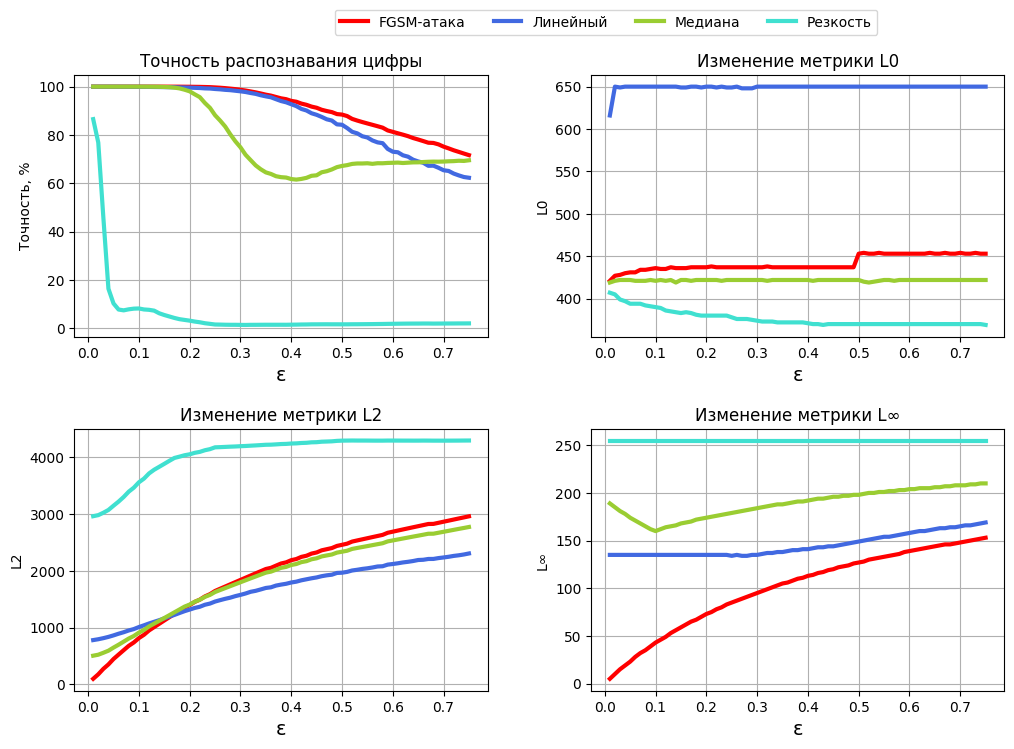

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(2, 2, figsize=(12, 8))

axis[0][0].plot(epsRange, FGSM_pred, label = "1", linewidth = 3, color = "red")
axis[0][0].plot(epsRange, FGSM_pred_linear, label = "1", linewidth = 3, color = "royalblue")
axis[0][0].plot(epsRange, FGSM_pred_median, label = "1", linewidth = 3, color = "yellowgreen")
axis[0][0].plot(epsRange, FGSM_pred_sharpe, label = "1", linewidth = 3, color = "turquoise")
axis[0][0].grid()
axis[0][0].set_xticks([0.1 * i for i in range(0, 8)])
axis[0][0].set_ylabel("Точность, %")
axis[0][0].set_xlabel("ε", fontsize = 14)
axis[0][0].set_title("Точность распознавания цифры")

lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

axis[0][1].plot(epsRange, FGSM_metrics[:, 0], label = "1", linewidth = 3, color = "red")
axis[0][1].plot(epsRange, FGSM_metrics_linear[:, 0], label = "1", linewidth = 3, color = "royalblue")
axis[0][1].plot(epsRange, FGSM_metrics_median[:, 0], label = "1", linewidth = 3, color = "yellowgreen")
axis[0][1].plot(epsRange, FGSM_metrics_sharpe[:, 0], label = "1", linewidth = 3, color = "turquoise")
axis[0][1].grid()
axis[0][1].set_xticks([0.1 * i for i in range(0, 8)])
axis[0][1].set_ylabel("L0")
axis[0][1].set_xlabel("ε", fontsize = 14)
axis[0][1].set_title("Изменение метрики L0")

axis[1][0].plot(epsRange, FGSM_metrics[:, 2], label = "1", linewidth = 3, color = "red")
axis[1][0].plot(epsRange, FGSM_metrics_linear[:, 2], label = "1", linewidth = 3, color = "royalblue")
axis[1][0].plot(epsRange, FGSM_metrics_median[:, 2], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][0].plot(epsRange, FGSM_metrics_sharpe[:, 2], label = "1", linewidth = 3, color = "turquoise")
axis[1][0].grid()
axis[1][0].set_xticks([0.1 * i for i in range(0, 8)])
axis[1][0].set_ylabel("L2")
axis[1][0].set_xlabel("ε", fontsize = 14)
axis[1][0].set_title("Изменение метрики L2")

axis[1][1].plot(epsRange, FGSM_metrics[:, 3], label = "1", linewidth = 3, color = "red")
axis[1][1].plot(epsRange, FGSM_metrics_linear[:, 3], label = "1", linewidth = 3, color = "royalblue")
axis[1][1].plot(epsRange, FGSM_metrics_median[:, 3], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][1].plot(epsRange, FGSM_metrics_sharpe[:, 3], label = "1", linewidth = 3, color = "turquoise")
axis[1][1].grid()
axis[1][1].set_xticks([0.1 * i for i in range(0, 8)])
axis[1][1].set_ylabel("L∞")
axis[1][1].set_xlabel("ε", fontsize = 14)
axis[1][1].set_title("Изменение метрики L∞")

fig.legend([lines[i] for i in [0,1,2,3]], ["FGSM-атака", "Линейный", "Медиана", "Резкость"], loc='upper right', bbox_to_anchor=(0.8, .97), ncol = 4)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.35)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
FGSM_results = [0 * i for i in range(0, 10)]
FGSM_results_median = [0 * i for i in range(0, 10)]

for i in range(0, len(epsRange)):
  res = model.predict(np.reshape(FGSM_advData[i], (1, 28, 28, 1)) / 255.)
  FGSM_results[np.argmax(res[0])] += 1

  res = model.predict(np.reshape(FGSM_adv_median[i], (1, 28, 28, 1)) / 255.)
  FGSM_results_median[np.argmax(res[0])] += 1

1/1 [==============================] - 0s 23ms/step


<Figure size 900x400 with 0 Axes>

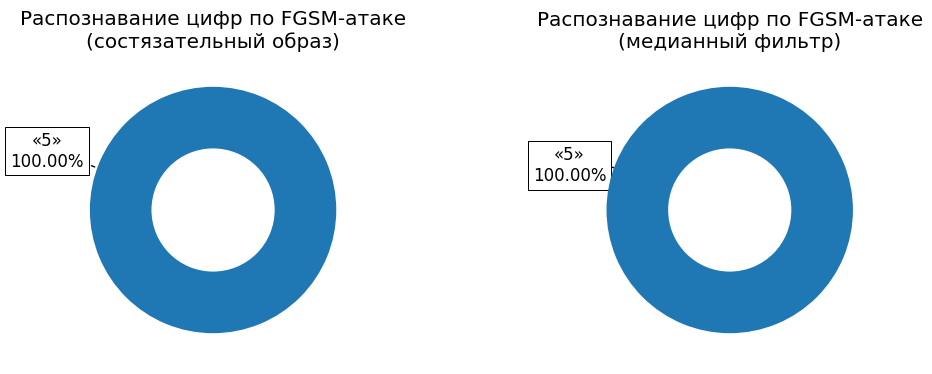

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

cifraLabels = ["«0»", "«1»", "«2»", "«3»", "«4»",
               "«5»", "«6»", "«7»", "«8»", "«9»"]

data_0 = []
label_0 = []
procent_0 = []
for i in range(0, 10):
  if FGSM_results[i] != 0:
    data_0.append(FGSM_results[i])
    label_0.append(cifraLabels[i])
    procent_0.append(FGSM_results[i] / np.sum(FGSM_results))

wedges, texts = axis[0].pie(data_0, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0].annotate("%s\n%.2f%%" % (label_0[i], procent_0[i] * 100),
                     xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0].set_title("Распознавание цифр по FGSM-атаке\n(состязательный образ)")

data_1 = []
label_1 = []
procent_1 = []
for i in range(0, 10):
  if FGSM_results_median[i] != 0:
    data_1.append(FGSM_results_median[i])
    label_1.append(cifraLabels[i])
    procent_1.append(FGSM_results_median[i] / np.sum(FGSM_results_median))

wedges, texts = axis[1].pie(data_1, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1].annotate("%s\n%.2f%%" % (label_1[i], procent_1[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1].set_title("Распознавание цифр по FGSM-атаке\n(медианный фильтр)")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
scaling = 4

png = Image.fromarray(preparePicture(FGSM_adv_median[24], scaling))
png.save("%s/FGSM/FGSM_eps0.25_median.png" % (path))
png = Image.fromarray(preparePicture(FGSM_adv_linear[24], scaling))
png.save("%s/FGSM/FGSM_eps0.25_linear.png" % (path))
png = Image.fromarray(preparePicture(FGSM_adv_sharpe[24], scaling))
png.save("%s/FGSM/FGSM_eps0.25_sharpe.png" % (path))

# Проверка пространственных фильтров против CW-атак

In [ ]:
img = np.asarray(Image.open("%s/CW/orig.png" % (path)))
origImg = preparePicture(img, 0.25)
CW_advData = np.load("%s/CW/CW_secondModel_nontar_xmpls.npy" % (path), allow_pickle=True)
CW_adv_linear = []
CW_adv_median = []
CW_adv_sharpe = []
CW_metrics = np.load("%s/CW/CW_secondModel_nontar_metrics.npy" % (path), allow_pickle=True)
CW_metrics_linear = []
CW_metrics_median = []
CW_metrics_sharpe = []
CW_pred = []
CW_pred_linear = []
CW_pred_median = []
CW_pred_sharpe = []

for i in range(0, len(CW_advData)):
  res = model.predict(np.reshape(CW_advData[i], (1, 28, 28, 1)) / 255.)
  CW_pred.append(res[0][5] * 100)

  CW_adv_linear.append(linearFilter(CW_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, CW_adv_linear[i])
  CW_metrics_linear.append([l0, l1, l2, l3])
  res = model.predict(np.reshape(CW_adv_linear[i], (1, 28, 28, 1)) / 255.)
  CW_pred_linear.append(res[0][5] * 100)

  CW_adv_median.append(medianFilter(CW_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, CW_adv_median[i])
  CW_metrics_median.append([l0, l1, l2, l3 ])
  res = model.predict(np.reshape(CW_adv_median[i], (1, 28, 28, 1)) / 255.)
  CW_pred_median.append(res[0][5] * 100)

  CW_adv_sharpe.append(sharpeningFilter(CW_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, CW_adv_sharpe[i])
  CW_metrics_sharpe.append([l0, l1, l2, l3 ])
  res = model.predict(np.reshape(CW_adv_sharpe[i], (1, 28, 28, 1)) / 255.)
  CW_pred_sharpe.append(res[0][5] * 100)

coefRange = [0.05 * i for i in range(1, 61)]
CW_adv_linear = np.asarray(CW_adv_linear)
CW_adv_median = np.asarray(CW_adv_median)
CW_adv_sharpe = np.asarray(CW_adv_sharpe)

CW_metrics_linear = np.asarray(CW_metrics_linear)
CW_metrics_median = np.asarray(CW_metrics_median)
CW_metrics_sharpe = np.asarray(CW_metrics_sharpe)
CW_pred = np.asarray(CW_pred)
CW_pred_linear = np.asarray(CW_pred_linear)
CW_pred_median = np.asarray(CW_pred_median)
CW_pred_sharpe = np.asarray(CW_pred_sharpe)

1/1 [==============================] - 0s 36ms/step


<Figure size 900x400 with 0 Axes>

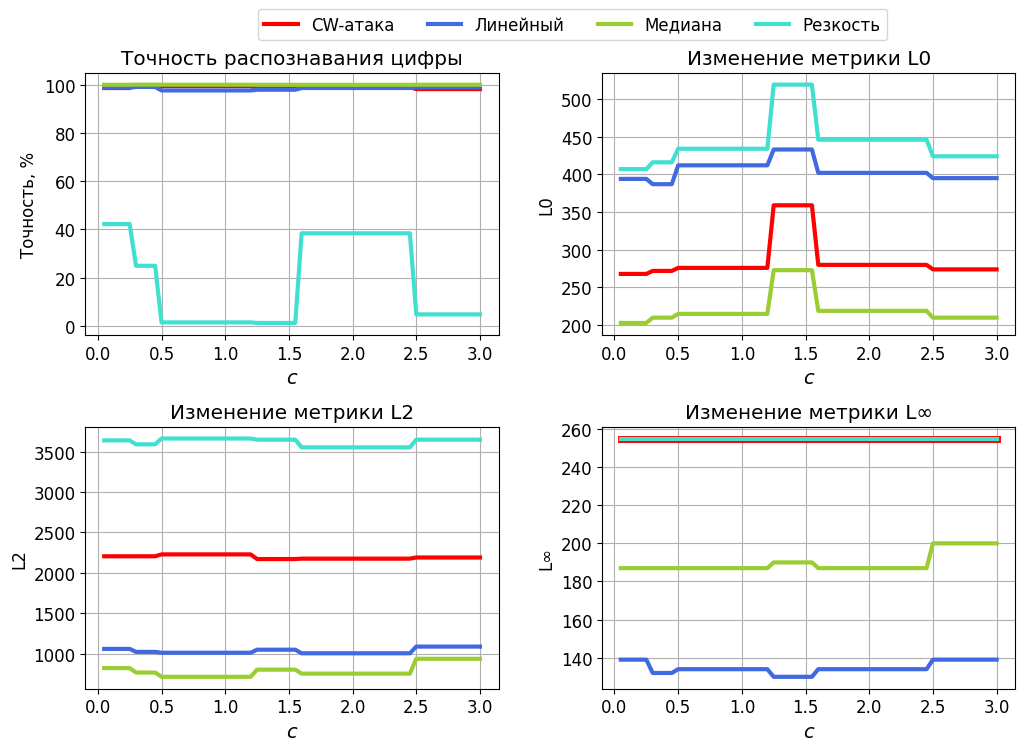

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(2, 2, figsize=(12, 8))

axis[0][0].plot(coefRange, CW_pred, label = "1", linewidth = 3, color = "red")
axis[0][0].plot(coefRange, CW_pred_linear, label = "1", linewidth = 3, color = "royalblue")
axis[0][0].plot(coefRange, CW_pred_median, label = "1", linewidth = 3, color = "yellowgreen")
axis[0][0].plot(coefRange, CW_pred_sharpe, label = "1", linewidth = 3, color = "turquoise")
axis[0][0].grid()
axis[0][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][0].set_ylabel("Точность, %")
axis[0][0].set_xlabel("${c}$", fontsize = 14)
axis[0][0].set_title("Точность распознавания цифры")

lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

axis[0][1].plot(coefRange, CW_metrics[:, 0], label = "1", linewidth = 3, color = "red")
axis[0][1].plot(coefRange, CW_metrics_linear[:, 0], label = "1", linewidth = 3, color = "royalblue")
axis[0][1].plot(coefRange, CW_metrics_median[:, 0], label = "1", linewidth = 3, color = "yellowgreen")
axis[0][1].plot(coefRange, CW_metrics_sharpe[:, 0], label = "1", linewidth = 3, color = "turquoise")
axis[0][1].grid()
axis[0][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][1].set_ylabel("L0")
axis[0][1].set_xlabel("${c}$", fontsize = 14)
axis[0][1].set_title("Изменение метрики L0")

axis[1][0].plot(coefRange, CW_metrics[:, 2], label = "1", linewidth = 3, color = "red")
axis[1][0].plot(coefRange, CW_metrics_linear[:, 2], label = "1", linewidth = 3, color = "royalblue")
axis[1][0].plot(coefRange, CW_metrics_median[:, 2], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][0].plot(coefRange, CW_metrics_sharpe[:, 2], label = "1", linewidth = 3, color = "turquoise")
axis[1][0].grid()
axis[1][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][0].set_ylabel("L2")
axis[1][0].set_xlabel("${c}$", fontsize = 14)
axis[1][0].set_title("Изменение метрики L2")

axis[1][1].plot(coefRange, CW_metrics[:, 3], label = "1", linewidth = 5, color = "red")
axis[1][1].plot(coefRange, CW_metrics_linear[:, 3], label = "1", linewidth = 3, color = "royalblue")
axis[1][1].plot(coefRange, CW_metrics_median[:, 3], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][1].plot(coefRange, CW_metrics_sharpe[:, 3], label = "1", linewidth = 3, color = "turquoise")
axis[1][1].grid()
axis[1][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][1].set_ylabel("L∞")
axis[1][1].set_xlabel("${c}$", fontsize = 14)
axis[1][1].set_title("Изменение метрики L∞")

fig.legend([lines[i] for i in [0,1,2,3]], ["CW-атака", "Линейный", "Медиана", "Резкость"], loc='upper right', bbox_to_anchor=(0.8, .97), ncol = 4)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.35)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
CW_results = [0 * i for i in range(0, 10)]
CW_results_median = [0 * i for i in range(0, 10)]

for i in range(0, len(coefRange)):
  res = model.predict(np.reshape(CW_advData[i], (1, 28, 28, 1)) / 255.)
  CW_results[np.argmax(res[0])] += 1

  res = model.predict(np.reshape(CW_adv_median[i], (1, 28, 28, 1)) / 255.)
  CW_results_median[np.argmax(res[0])] += 1

1/1 [==============================] - 0s 32ms/step


<Figure size 900x400 with 0 Axes>

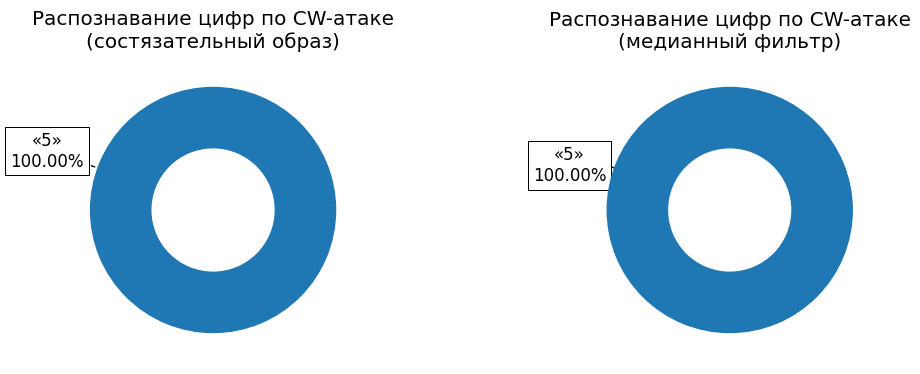

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

cifraLabels = ["«0»", "«1»", "«2»", "«3»", "«4»",
               "«5»", "«6»", "«7»", "«8»", "«9»"]

data_0 = []
label_0 = []
procent_0 = []
for i in range(0, 10):
  if CW_results[i] != 0:
    data_0.append(CW_results[i])
    label_0.append(cifraLabels[i])
    procent_0.append(CW_results[i] / np.sum(CW_results))

wedges, texts = axis[0].pie(data_0, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0].annotate("%s\n%.2f%%" % (label_0[i], procent_0[i] * 100),
                     xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0].set_title("Распознавание цифр по CW-атаке\n(состязательный образ)")

data_1 = []
label_1 = []
procent_1 = []
for i in range(0, 10):
  if CW_results_median[i] != 0:
    data_1.append(CW_results_median[i])
    label_1.append(cifraLabels[i])
    procent_1.append(CW_results_median[i] / np.sum(CW_results_median))

wedges, texts = axis[1].pie(data_1, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1].annotate("%s\n%.2f%%" % (label_1[i], procent_1[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1].set_title("Распознавание цифр по CW-атаке\n(медианный фильтр)")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
scaling = 4

png = Image.fromarray(preparePicture(CW_adv_median[24], scaling))
png.save("%s/CW/CW_nontar_c1.25_median.png" % (path))
png = Image.fromarray(preparePicture(CW_adv_linear[24], scaling))
png.save("%s/CW/CW_nontar_c1.25_linear.png" % (path))
png = Image.fromarray(preparePicture(CW_adv_sharpe[24], scaling))
png.save("%s/CW/CW_nontar_c1.25_sharpe.png" % (path))

# Проверка пространственных фильтров против DF-атак

In [ ]:
img = np.asarray(Image.open("%s/DF/orig.png" % (path)))
origImg = preparePicture(img, 0.25)
DF_advData = np.load("%s/DF/DF_secondModel_xmpls.npy" % (path), allow_pickle=True)
DF_adv_linear = []
DF_adv_median = []
DF_adv_sharpe = []
DF_metrics = np.load("%s/DF/DF_secondModel_metrics.npy" % (path), allow_pickle=True)
DF_metrics_linear = []
DF_metrics_median = []
DF_metrics_sharpe = []
DF_pred = []
DF_pred_linear = []
DF_pred_median = []
DF_pred_sharpe = []

for i in range(0, len(DF_advData)):
  res = model.predict(np.reshape(DF_advData[i], (1, 28, 28, 1)) / 255.)
  DF_pred.append(res[0][5] * 100)

  DF_adv_linear.append(linearFilter(DF_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, DF_adv_linear[i])
  DF_metrics_linear.append([l0, l1, l2, l3])
  res = model.predict(np.reshape(DF_adv_linear[i], (1, 28, 28, 1)) / 255.)
  DF_pred_linear.append(res[0][5] * 100)

  DF_adv_median.append(medianFilter(DF_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, DF_adv_median[i])
  DF_metrics_median.append([l0, l1, l2, l3 ])
  res = model.predict(np.reshape(DF_adv_median[i], (1, 28, 28, 1)) / 255.)
  DF_pred_median.append(res[0][5] * 100)

  DF_adv_sharpe.append(sharpeningFilter(DF_advData[i]))
  l0, l1, l2, l3 = Metrics(origImg, DF_adv_sharpe[i])
  DF_metrics_sharpe.append([l0, l1, l2, l3 ])
  res = model.predict(np.reshape(DF_adv_sharpe[i], (1, 28, 28, 1)) / 255.)
  DF_pred_sharpe.append(res[0][5] * 100)

overshootRange = [0.05 * i for i in range(1, 61)]
DF_adv_linear = np.asarray(DF_adv_linear)
DF_adv_median = np.asarray(DF_adv_median)
DF_adv_sharpe = np.asarray(DF_adv_sharpe)

DF_metrics_linear = np.asarray(DF_metrics_linear)
DF_metrics_median = np.asarray(DF_metrics_median)
DF_metrics_sharpe = np.asarray(DF_metrics_sharpe)
DF_pred = np.asarray(DF_pred)
DF_pred_linear = np.asarray(DF_pred_linear)
DF_pred_median = np.asarray(DF_pred_median)
DF_pred_sharpe = np.asarray(DF_pred_sharpe)

1/1 [==============================] - 0s 49ms/step


<Figure size 900x400 with 0 Axes>

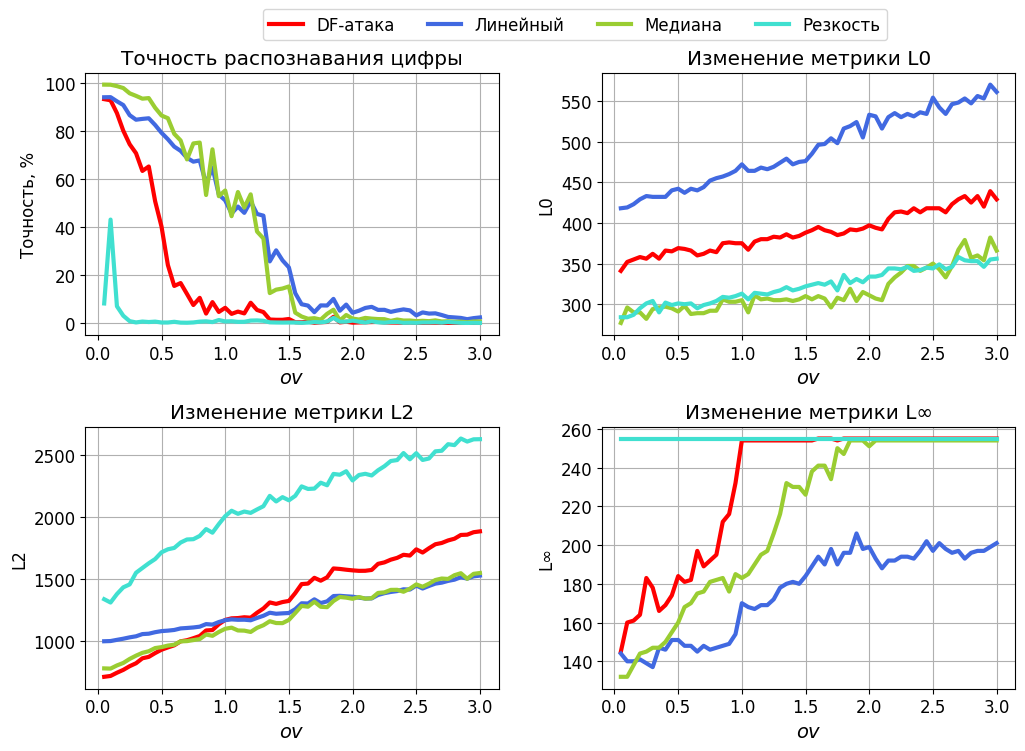

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(2, 2, figsize=(12, 8))

axis[0][0].plot(overshootRange, DF_pred, label = "1", linewidth = 3, color = "red")
axis[0][0].plot(overshootRange, DF_pred_linear, label = "1", linewidth = 3, color = "royalblue")
axis[0][0].plot(overshootRange, DF_pred_median, label = "1", linewidth = 3, color = "yellowgreen")
axis[0][0].plot(overshootRange, DF_pred_sharpe, label = "1", linewidth = 3, color = "turquoise")
axis[0][0].grid()
axis[0][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][0].set_ylabel("Точность, %")
axis[0][0].set_xlabel("${ov}$", fontsize = 14)
axis[0][0].set_title("Точность распознавания цифры")

lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

axis[0][1].plot(overshootRange, DF_metrics[:, 0], label = "1", linewidth = 3, color = "red")
axis[0][1].plot(overshootRange, DF_metrics_linear[:, 0], label = "1", linewidth = 3, color = "royalblue")
axis[0][1].plot(overshootRange, DF_metrics_median[:, 0], label = "1", linewidth = 3, color = "yellowgreen")
axis[0][1].plot(overshootRange, DF_metrics_sharpe[:, 0], label = "1", linewidth = 3, color = "turquoise")
axis[0][1].grid()
axis[0][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][1].set_ylabel("L0")
axis[0][1].set_xlabel("${ov}$", fontsize = 14)
axis[0][1].set_title("Изменение метрики L0")

axis[1][0].plot(overshootRange, DF_metrics[:, 2], label = "1", linewidth = 3, color = "red")
axis[1][0].plot(overshootRange, DF_metrics_linear[:, 2], label = "1", linewidth = 3, color = "royalblue")
axis[1][0].plot(overshootRange, DF_metrics_median[:, 2], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][0].plot(overshootRange, DF_metrics_sharpe[:, 2], label = "1", linewidth = 3, color = "turquoise")
axis[1][0].grid()
axis[1][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][0].set_ylabel("L2")
axis[1][0].set_xlabel("${ov}$", fontsize = 14)
axis[1][0].set_title("Изменение метрики L2")

axis[1][1].plot(overshootRange, DF_metrics[:, 3], label = "1", linewidth = 3, color = "red")
axis[1][1].plot(overshootRange, DF_metrics_linear[:, 3], label = "1", linewidth = 3, color = "royalblue")
axis[1][1].plot(overshootRange, DF_metrics_median[:, 3], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][1].plot(overshootRange, DF_metrics_sharpe[:, 3], label = "1", linewidth = 3, color = "turquoise")
axis[1][1].grid()
axis[1][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][1].set_ylabel("L∞")
axis[1][1].set_xlabel("${ov}$", fontsize = 14)
axis[1][1].set_title("Изменение метрики L∞")

fig.legend([lines[i] for i in [0,1,2,3]], ["DF-атака", "Линейный", "Медиана", "Резкость"], loc='upper right', bbox_to_anchor=(0.8, .97), ncol = 4)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.35)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
DF_results = [0 * i for i in range(0, 10)]
DF_results_median = [0 * i for i in range(0, 10)]

for i in range(0, len(overshootRange)):
  res = model.predict(np.reshape(DF_advData[i], (1, 28, 28, 1)) / 255.)
  DF_results[np.argmax(res[0])] += 1

  res = model.predict(np.reshape(DF_adv_median[i], (1, 28, 28, 1)) / 255.)
  DF_results_median[np.argmax(res[0])] += 1

1/1 [==============================] - 0s 40ms/step


<Figure size 900x400 with 0 Axes>

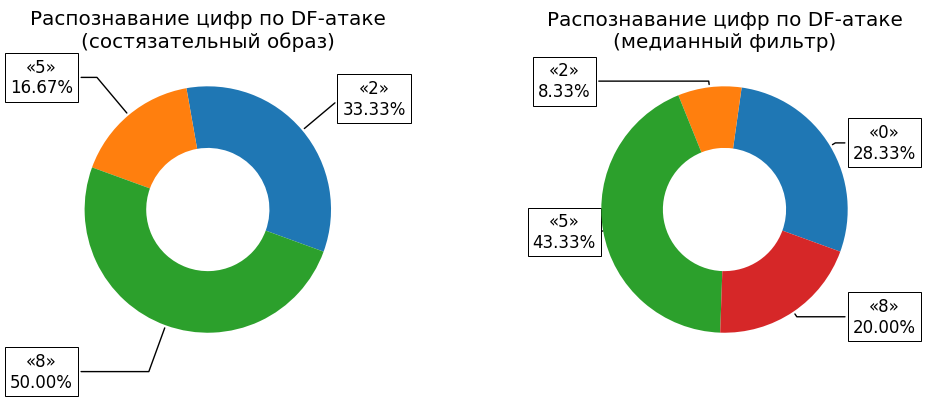

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

cifraLabels = ["«0»", "«1»", "«2»", "«3»", "«4»",
               "«5»", "«6»", "«7»", "«8»", "«9»"]

data_0 = []
label_0 = []
procent_0 = []
for i in range(0, 10):
  if DF_results[i] != 0:
    data_0.append(DF_results[i])
    label_0.append(cifraLabels[i])
    procent_0.append(DF_results[i] / np.sum(DF_results))

wedges, texts = axis[0].pie(data_0, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0].annotate("%s\n%.2f%%" % (label_0[i], procent_0[i] * 100),
                     xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0].set_title("Распознавание цифр по DF-атаке\n(состязательный образ)")

data_1 = []
label_1 = []
procent_1 = []
for i in range(0, 10):
  if DF_results_median[i] != 0:
    data_1.append(DF_results_median[i])
    label_1.append(cifraLabels[i])
    procent_1.append(DF_results_median[i] / np.sum(DF_results_median))

wedges, texts = axis[1].pie(data_1, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1].annotate("%s\n%.2f%%" % (label_1[i], procent_1[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1].set_title("Распознавание цифр по DF-атаке\n(медианный фильтр)")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
scaling = 4

png = Image.fromarray(preparePicture(DF_adv_median[24], scaling))
png.save("%s/DF/DF_ov1.25_median.png" % (path))
png = Image.fromarray(preparePicture(DF_adv_linear[24], scaling))
png.save("%s/DF/DF_ov1.25_linear.png" % (path))
png = Image.fromarray(preparePicture(DF_adv_sharpe[24], scaling))
png.save("%s/DF/DF_ov1.25_sharpe.png" % (path))

# Фурье фильтр при нейтрализации атак

In [ ]:
img = np.asarray(Image.open("%s/FGSM/orig.png" % (path)))
FGSM_origImg = preparePicture(img, 0.25)
img = np.asarray(Image.open("%s/CW/orig.png" % (path)))
CW_origImg = preparePicture(img, 0.25)
img = np.asarray(Image.open("%s/DF/orig.png" % (path)))
DF_origImg = preparePicture(img, 0.25)

In [ ]:
cifras = np.asarray([FGSM_origImg, CW_origImg, DF_origImg])

FGSM_advData = np.load("%s/FGSM/FGSM_secondModel_xmpls.npy" % (path), allow_pickle=True)
CW_advData = np.load("%s/CW/CW_secondModel_nontar_xmpls.npy" % (path), allow_pickle=True)
DF_advData = np.load("%s/DF/DF_secondModel_xmpls.npy" % (path), allow_pickle=True)
cifras_furie = []
FGSM_adv_furie = []
CW_adv_furie = []
DF_adv_furie = []

radiuses = list(range(40))
labels = np.ones(100) * 5
labels = keras.utils.to_categorical(np.array(labels), 10)

In [ ]:
for rad in radiuses:
  print("Radius: %d" % rad)
  temp = []
  for i in range(0, 3):
    temp.append(FourierFrequencyFiltering(cifras[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:3], batch_size=1)
  cifras_furie.append(tempRes[1] * 100)

  temp = []
  for i in range(0, 75):
    temp.append(FourierFrequencyFiltering(FGSM_advData[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:75], batch_size=1)
  FGSM_adv_furie.append(tempRes[1] * 100)

  temp = []
  for i in range(0, 60):
    temp.append(FourierFrequencyFiltering(CW_advData[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:60], batch_size=1)
  CW_adv_furie.append(tempRes[1] * 100)

  temp = []
  for i in range(0, 60):
    temp.append(FourierFrequencyFiltering(DF_advData[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:60], batch_size=1)
  DF_adv_furie.append(tempRes[1] * 100)

Radius: 0
60/60 [==============================] - 0s 6ms/step - loss: 3.9805 - accuracy: 0.0000e+00
Radius: 1
60/60 [==============================] - 0s 4ms/step - loss: 2.5940 - accuracy: 0.0000e+00
Radius: 2
60/60 [==============================] - 0s 3ms/step - loss: 2.5987 - accuracy: 0.0000e+00
Radius: 3
60/60 [==============================] - 0s 3ms/step - loss: 2.6916 - accuracy: 0.0000e+00
Radius: 4
60/60 [==============================] - 0s 4ms/step - loss: 2.6960 - accuracy: 0.0000e+00
Radius: 5
60/60 [==============================] - 0s 3ms/step - loss: 2.4420 - accuracy: 0.0000e+00
Radius: 6
60/60 [==============================] - 0s 6ms/step - loss: 2.2194 - accuracy: 0.0000e+00
Radius: 7
60/60 [==============================] - 0s 4ms/step - loss: 2.0735 - accuracy: 0.0000e+00
Radius: 8
60/60 [==============================] - 0s 3ms/step - loss: 1.6879 - accuracy: 0.5167
Radius: 9
60/60 [==============================] - 0s 3ms/step - loss: 1.2919 - accuracy: 0.666

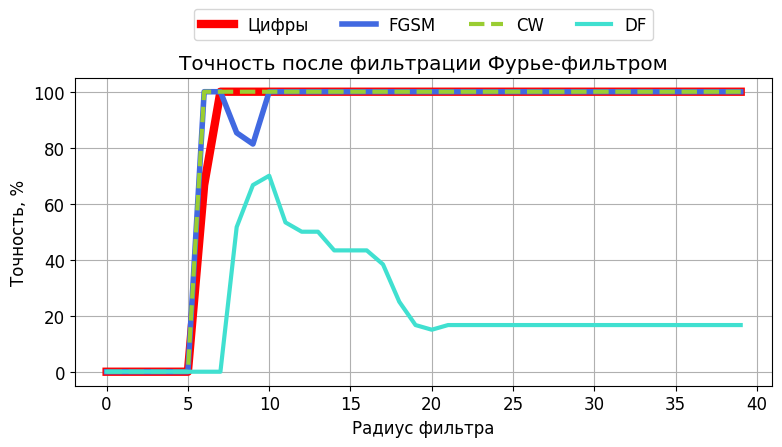

In [ ]:
plt.figure(figsize=[9, 4])
plt.plot(radiuses, cifras_furie, label = "Цифры", linewidth = 6, color = "red")
plt.plot(radiuses, FGSM_adv_furie, label = "FGSM", linewidth = 4, color = "royalblue")
plt.plot(radiuses, CW_adv_furie, label = "CW", linewidth = 3, color = "yellowgreen", linestyle="dashed")
plt.plot(radiuses, DF_adv_furie, label = "DF", linewidth = 3, color = "turquoise")
plt.grid()
plt.ylabel("Точность, %")
plt.xlabel("Радиус фильтра")
plt.title("Точность после фильтрации Фурье-фильтром")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4)

plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
DF_furie = []
DF_metrics = np.load("%s/DF/DF_secondModel_metrics.npy" % (path), allow_pickle=True)
DF_metrics_furie = []
DF_pred = []
DF_pred_furie = []

for i in range(0, len(DF_advData)):
  res = model.predict(np.reshape(DF_advData[i], (1, 28, 28, 1)) / 255.)
  DF_pred.append(res[0][5] * 100)

  DF_furie.append(FourierFrequencyFiltering(DF_advData[i], 10))
  l0, l1, l2, l3 = Metrics(DF_origImg, DF_furie[i])
  DF_metrics_furie.append([l0, l1, l2, l3])
  res = model.predict(np.reshape(DF_furie[i], (1, 28, 28, 1)) / 255.)
  DF_pred_furie.append(res[0][5] * 100)

overshootRange = [0.05 * i for i in range(1, 61)]
DF_furie = np.asarray(DF_furie)
DF_metrics_furie = np.asarray(DF_metrics_furie)
DF_pred = np.asarray(DF_pred)
DF_pred_furie = np.asarray(DF_pred_furie)

1/1 [==============================] - 0s 37ms/step


<Figure size 900x400 with 0 Axes>

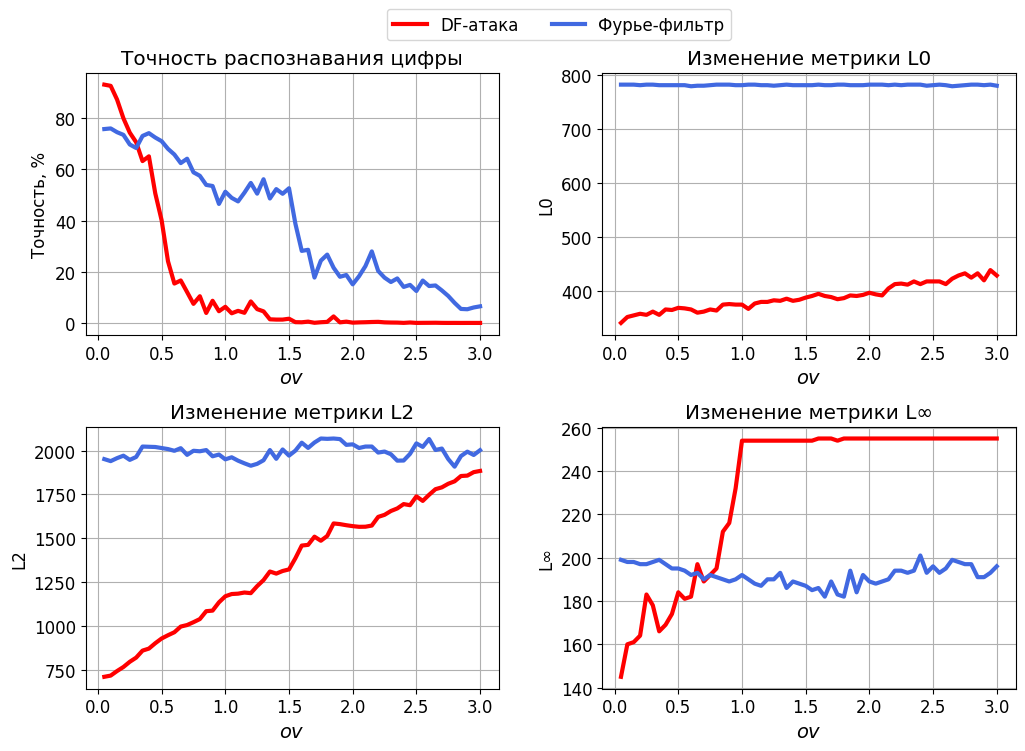

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(2, 2, figsize=(12, 8))

axis[0][0].plot(overshootRange, DF_pred, label = "1", linewidth = 3, color = "red")
axis[0][0].plot(overshootRange, DF_pred_furie, label = "1", linewidth = 3, color = "royalblue")
axis[0][0].grid()
axis[0][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][0].set_ylabel("Точность, %")
axis[0][0].set_xlabel("${ov}$", fontsize = 14)
axis[0][0].set_title("Точность распознавания цифры")

lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

axis[0][1].plot(overshootRange, DF_metrics[:, 0], label = "1", linewidth = 3, color = "red")
axis[0][1].plot(overshootRange, DF_metrics_furie[:, 0], label = "1", linewidth = 3, color = "royalblue")
axis[0][1].grid()
axis[0][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][1].set_ylabel("L0")
axis[0][1].set_xlabel("${ov}$", fontsize = 14)
axis[0][1].set_title("Изменение метрики L0")

axis[1][0].plot(overshootRange, DF_metrics[:, 2], label = "1", linewidth = 3, color = "red")
axis[1][0].plot(overshootRange, DF_metrics_furie[:, 2], label = "1", linewidth = 3, color = "royalblue")
axis[1][0].grid()
axis[1][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][0].set_ylabel("L2")
axis[1][0].set_xlabel("${ov}$", fontsize = 14)
axis[1][0].set_title("Изменение метрики L2")

axis[1][1].plot(overshootRange, DF_metrics[:, 3], label = "1", linewidth = 3, color = "red")
axis[1][1].plot(overshootRange, DF_metrics_furie[:, 3], label = "1", linewidth = 3, color = "royalblue")
axis[1][1].grid()
axis[1][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][1].set_ylabel("L∞")
axis[1][1].set_xlabel("${ov}$", fontsize = 14)
axis[1][1].set_title("Изменение метрики L∞")

fig.legend([lines[i] for i in [0,1]], ["DF-атака", "Фурье-фильтр"], loc='upper right', bbox_to_anchor=(0.67, .97), ncol = 4)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.35)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
DF_results = [0 * i for i in range(0, 10)]
DF_results_furie = [0 * i for i in range(0, 10)]

for i in range(0, len(overshootRange)):
  res = model.predict(np.reshape(DF_advData[i], (1, 28, 28, 1)) / 255.)
  DF_results[np.argmax(res[0])] += 1

  res = model.predict(np.reshape(DF_furie[i], (1, 28, 28, 1)) / 255.)
  DF_results_furie[np.argmax(res[0])] += 1

1/1 [==============================] - 0s 33ms/step


<Figure size 900x400 with 0 Axes>

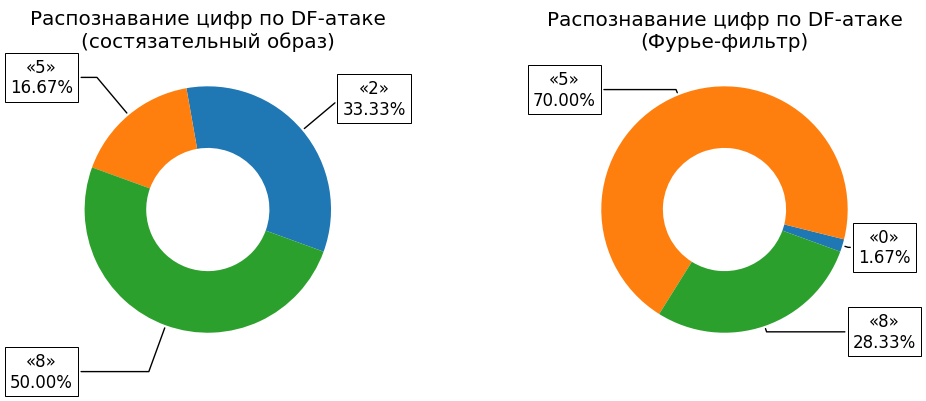

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

cifraLabels = ["«0»", "«1»", "«2»", "«3»", "«4»",
               "«5»", "«6»", "«7»", "«8»", "«9»"]

data_0 = []
label_0 = []
procent_0 = []
for i in range(0, 10):
  if DF_results[i] != 0:
    data_0.append(DF_results[i])
    label_0.append(cifraLabels[i])
    procent_0.append(DF_results[i] / np.sum(DF_results))

wedges, texts = axis[0].pie(data_0, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0].annotate("%s\n%.2f%%" % (label_0[i], procent_0[i] * 100),
                     xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0].set_title("Распознавание цифр по DF-атаке\n(состязательный образ)")

data_1 = []
label_1 = []
procent_1 = []
for i in range(0, 10):
  if DF_results_furie[i] != 0:
    data_1.append(DF_results_furie[i])
    label_1.append(cifraLabels[i])
    procent_1.append(DF_results_furie[i] / np.sum(DF_results_furie))

wedges, texts = axis[1].pie(data_1, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1].annotate("%s\n%.2f%%" % (label_1[i], procent_1[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1].set_title("Распознавание цифр по DF-атаке\n(Фурье-фильтр)")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.rcParams.update({'font.size': 12})
plt.show()

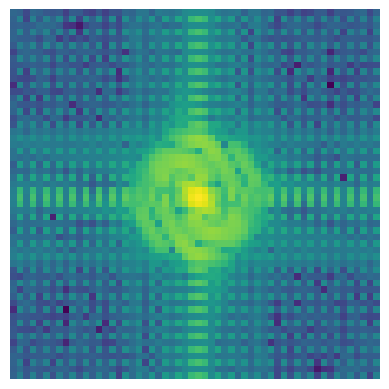

In [ ]:
import math as mt
scaling = 4
image = DF_advData[24]

M, N = image.shape
P, Q = 2 * M, 2 * N
f_p = np.zeros((P, Q))
f_p[0:M, 0:N] = np.array(image, copy=True) / 255.
a0 = np.array(list(range(0, P)))
b0 = np.array(list(range(0, Q)))
a = np.transpose(np.matlib.repmat(a0, Q, 1)) + np.matlib.repmat(b0, P, 1)
a = (-1) ** a
f_p = f_p * a
F = np.fft.fft2(f_p)
H = np.zeros((P, Q))
for i in range(0, P):
    for j in range(0, Q):
        if (round(i - P / 2) ** 2 + round(j - Q / 2) ** 2 <= 10 ** 2):
            H[i][j] = 1
G = H * F

spector = np.reshape(np.array([mt.log10(x) for x in np.reshape(abs(F), (1,-1))[0]]), (P,Q))
filterWindow = abs(G)
furieImg = FourierFrequencyFiltering(image, 10)

image = furieImg
M, N = image.shape
P, Q = 2 * M, 2 * N
f_p = np.zeros((P, Q))
f_p[0:M, 0:N] = np.array(image, copy=True) / 255.
a0 = np.array(list(range(0, P)))
b0 = np.array(list(range(0, Q)))
a = np.transpose(np.matlib.repmat(a0, Q, 1)) + np.matlib.repmat(b0, P, 1)
a = (-1) ** a
f_p = f_p * a
F = np.fft.fft2(f_p)

spector_after = np.reshape(np.array([mt.log10(x) for x in np.reshape(abs(F), (1,-1))[0]]), (P,Q))

plt.imshow(spector)
plt.axis('off')

plt.imshow(spector)
plt.axis('off')
plt.savefig("%s/DF/DF_ov1.25_spectorfurie10.png" % (path), bbox_inches='tight', pad_inches=0)

plt.imshow(filterWindow)
plt.axis('off')
plt.savefig("%s/DF/DF_ov1.25_filterWindowfurie10.png" % (path), bbox_inches='tight', pad_inches=0)

plt.imshow(spector_after)
plt.axis('off')
plt.savefig("%s/DF/DF_ov1.25_apectorAfterFurie10.png" % (path), bbox_inches='tight', pad_inches=0)

png = Image.fromarray(preparePicture(furieImg, scaling))
png.save("%s/DF/DF_ov1.25_furie10.png" % (path))

# Двусторонний фильтр

In [ ]:
img = np.asarray(Image.open("%s/FGSM/orig.png" % (path)))
FGSM_origImg = preparePicture(img, 0.25)
img = np.asarray(Image.open("%s/CW/orig.png" % (path)))
CW_origImg = preparePicture(img, 0.25)
img = np.asarray(Image.open("%s/DF/orig.png" % (path)))
DF_origImg = preparePicture(img, 0.25)

In [ ]:
cifras = np.asarray([FGSM_origImg, CW_origImg, DF_origImg])

FGSM_advData = np.load("%s/FGSM/FGSM_secondModel_xmpls.npy" % (path), allow_pickle=True)
CW_advData = np.load("%s/CW/CW_secondModel_nontar_xmpls.npy" % (path), allow_pickle=True)
DF_advData = np.load("%s/DF/DF_secondModel_xmpls.npy" % (path), allow_pickle=True)
cifras_bil = []
FGSM_adv_bil = []
CW_adv_bil = []
DF_adv_bil = []

radiuses = list(range(28))
labels = np.ones(100) * 5
labels = keras.utils.to_categorical(np.array(labels), 10)

In [ ]:
for rad in radiuses:
  print("Radius: %d" % rad)
  temp = []
  for i in range(0, 3):
    temp.append(cv2.bilateralFilter(cifras[i], rad, 75, 75))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:3], batch_size=1)
  cifras_bil.append(tempRes[1] * 100)

  temp = []
  for i in range(0, 75):
    temp.append(cv2.bilateralFilter(FGSM_advData[i], rad, 75, 75))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:75], batch_size=1)
  FGSM_adv_bil.append(tempRes[1] * 100)

  temp = []
  for i in range(0, 60):
    temp.append(cv2.bilateralFilter(CW_advData[i], rad, 75, 75))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:60], batch_size=1)
  CW_adv_bil.append(tempRes[1] * 100)

  temp = []
  for i in range(0, 60):
    temp.append(cv2.bilateralFilter(DF_advData[i], rad, 75, 75))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = model.evaluate(temp, labels[0:60], batch_size=1)
  DF_adv_bil.append(tempRes[1] * 100)

Radius: 0
60/60 [==============================] - 0s 7ms/step - loss: 2.8785 - accuracy: 0.2833
Radius: 1
60/60 [==============================] - 0s 3ms/step - loss: 4.0192 - accuracy: 0.2833
Radius: 2
60/60 [==============================] - 0s 4ms/step - loss: 4.0192 - accuracy: 0.2833
Radius: 3
60/60 [==============================] - 0s 4ms/step - loss: 4.0192 - accuracy: 0.2833
Radius: 4
60/60 [==============================] - 0s 4ms/step - loss: 3.4838 - accuracy: 0.3500
Radius: 5
60/60 [==============================] - 0s 4ms/step - loss: 3.4838 - accuracy: 0.3500
Radius: 6
60/60 [==============================] - 0s 4ms/step - loss: 3.3684 - accuracy: 0.3000
Radius: 7
60/60 [==============================] - 0s 3ms/step - loss: 3.3684 - accuracy: 0.3000
Radius: 8
60/60 [==============================] - 0s 4ms/step - loss: 3.4750 - accuracy: 0.2000
Radius: 9
60/60 [==============================] - 0s 6ms/step - loss: 3.4750 - accuracy: 0.2000
Radius: 10
60/60 [============

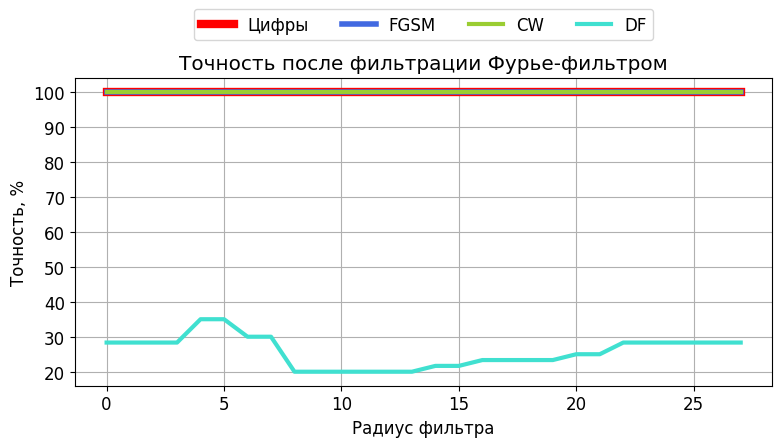

In [ ]:
plt.figure(figsize=[9, 4])
plt.plot(radiuses, cifras_bil, label = "Цифры", linewidth = 6, color = "red")
plt.plot(radiuses, FGSM_adv_bil, label = "FGSM", linewidth = 4, color = "royalblue")
plt.plot(radiuses, CW_adv_bil, label = "CW", linewidth = 3, color = "yellowgreen")
plt.plot(radiuses, DF_adv_bil, label = "DF", linewidth = 3, color = "turquoise")
plt.grid()
plt.ylabel("Точность, %")
plt.xlabel("Радиус фильтра")
plt.title("Точность после фильтрации Фурье-фильтром")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4)

plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
DF_bil = []
DF_metrics = np.load("%s/DF/DF_secondModel_metrics.npy" % (path), allow_pickle=True)
DF_metrics_bil = []
DF_pred = []
DF_pred_bil = []

for i in range(0, len(DF_advData)):
  res = model.predict(np.reshape(DF_advData[i], (1, 28, 28, 1)) / 255.)
  DF_pred.append(res[0][5] * 100)

  DF_bil.append(cv2.bilateralFilter(DF_advData[i], 15, 75, 75))
  l0, l1, l2, l3 = Metrics(DF_origImg, DF_bil[i])
  DF_metrics_bil.append([l0, l1, l2, l3])
  res = model.predict(np.reshape(DF_bil[i], (1, 28, 28, 1)) / 255.)
  DF_pred_bil.append(res[0][5] * 100)

overshootRange = [0.05 * i for i in range(1, 61)]
DF_bil = np.asarray(DF_bil)
DF_metrics_bil = np.asarray(DF_metrics_bil)
DF_pred = np.asarray(DF_pred)
DF_pred_bil = np.asarray(DF_pred_bil)

1/1 [==============================] - 0s 45ms/step


<Figure size 900x400 with 0 Axes>

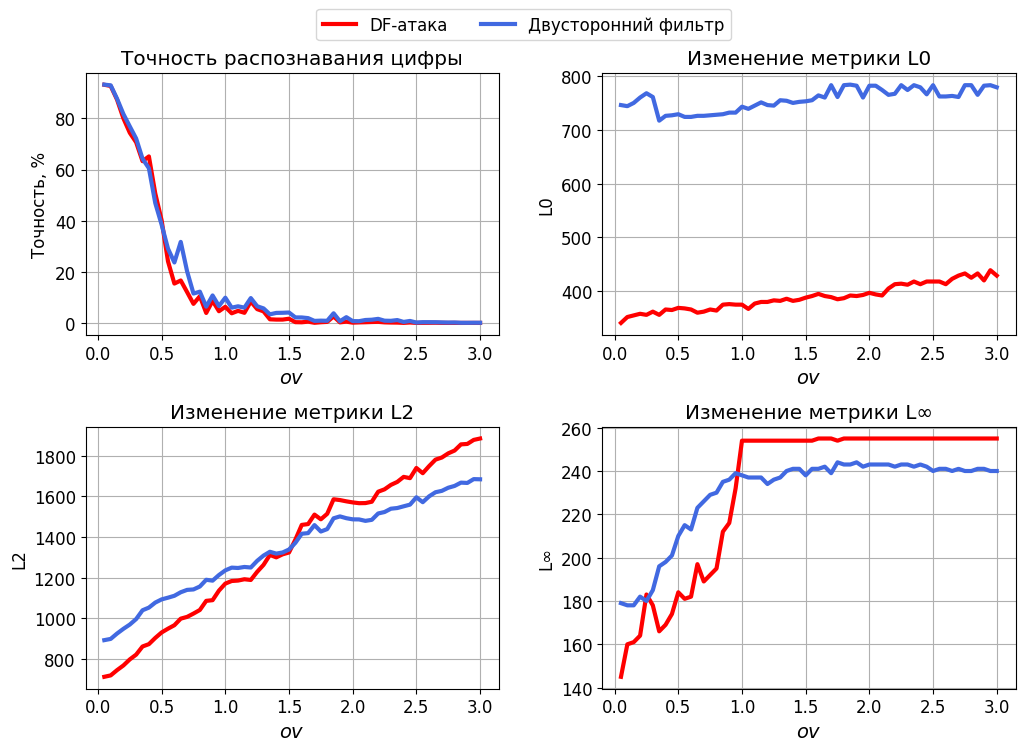

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(2, 2, figsize=(12, 8))

axis[0][0].plot(overshootRange, DF_pred, label = "1", linewidth = 3, color = "red")
axis[0][0].plot(overshootRange, DF_pred_bil, label = "1", linewidth = 3, color = "royalblue")
axis[0][0].grid()
axis[0][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][0].set_ylabel("Точность, %")
axis[0][0].set_xlabel("${ov}$", fontsize = 14)
axis[0][0].set_title("Точность распознавания цифры")

lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

axis[0][1].plot(overshootRange, DF_metrics[:, 0], label = "1", linewidth = 3, color = "red")
axis[0][1].plot(overshootRange, DF_metrics_bil[:, 0], label = "1", linewidth = 3, color = "royalblue")
axis[0][1].grid()
axis[0][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][1].set_ylabel("L0")
axis[0][1].set_xlabel("${ov}$", fontsize = 14)
axis[0][1].set_title("Изменение метрики L0")

axis[1][0].plot(overshootRange, DF_metrics[:, 2], label = "1", linewidth = 3, color = "red")
axis[1][0].plot(overshootRange, DF_metrics_bil[:, 2], label = "1", linewidth = 3, color = "royalblue")
axis[1][0].grid()
axis[1][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][0].set_ylabel("L2")
axis[1][0].set_xlabel("${ov}$", fontsize = 14)
axis[1][0].set_title("Изменение метрики L2")

axis[1][1].plot(overshootRange, DF_metrics[:, 3], label = "1", linewidth = 3, color = "red")
axis[1][1].plot(overshootRange, DF_metrics_bil[:, 3], label = "1", linewidth = 3, color = "royalblue")
axis[1][1].grid()
axis[1][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][1].set_ylabel("L∞")
axis[1][1].set_xlabel("${ov}$", fontsize = 14)
axis[1][1].set_title("Изменение метрики L∞")

fig.legend([lines[i] for i in [0,1]], ["DF-атака", "Двусторонний фильтр"], loc='upper right', bbox_to_anchor=(0.67, .97), ncol = 4)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.35)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
DF_results = [0 * i for i in range(0, 10)]
DF_results_bil = [0 * i for i in range(0, 10)]

for i in range(0, len(overshootRange)):
  res = model.predict(np.reshape(DF_advData[i], (1, 28, 28, 1)) / 255.)
  DF_results[np.argmax(res[0])] += 1

  res = model.predict(np.reshape(DF_bil[i], (1, 28, 28, 1)) / 255.)
  DF_results_bil[np.argmax(res[0])] += 1

1/1 [==============================] - 0s 35ms/step


<Figure size 900x400 with 0 Axes>

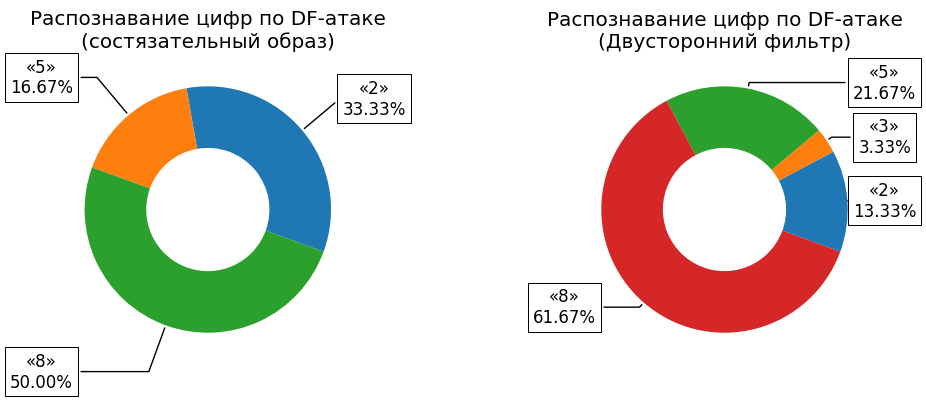

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

cifraLabels = ["«0»", "«1»", "«2»", "«3»", "«4»",
               "«5»", "«6»", "«7»", "«8»", "«9»"]

data_0 = []
label_0 = []
procent_0 = []
for i in range(0, 10):
  if DF_results[i] != 0:
    data_0.append(DF_results[i])
    label_0.append(cifraLabels[i])
    procent_0.append(DF_results[i] / np.sum(DF_results))

wedges, texts = axis[0].pie(data_0, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0].annotate("%s\n%.2f%%" % (label_0[i], procent_0[i] * 100),
                     xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0].set_title("Распознавание цифр по DF-атаке\n(состязательный образ)")

data_1 = []
label_1 = []
procent_1 = []
for i in range(0, 10):
  if DF_results_bil[i] != 0:
    data_1.append(DF_results_bil[i])
    label_1.append(cifraLabels[i])
    procent_1.append(DF_results_bil[i] / np.sum(DF_results_bil))

wedges, texts = axis[1].pie(data_1, wedgeprops=dict(width=0.5), startangle=-20)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1].annotate("%s\n%.2f%%" % (label_1[i], procent_1[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1].set_title("Распознавание цифр по DF-атаке\n(Двусторонний фильтр)")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
scaling = 4

png = Image.fromarray(preparePicture(DF_bil[24], scaling))
png.save("%s/DF/DF_ov1.25_bil.png" % (path))

# DF под всеми фильтрами

<Figure size 900x400 with 0 Axes>

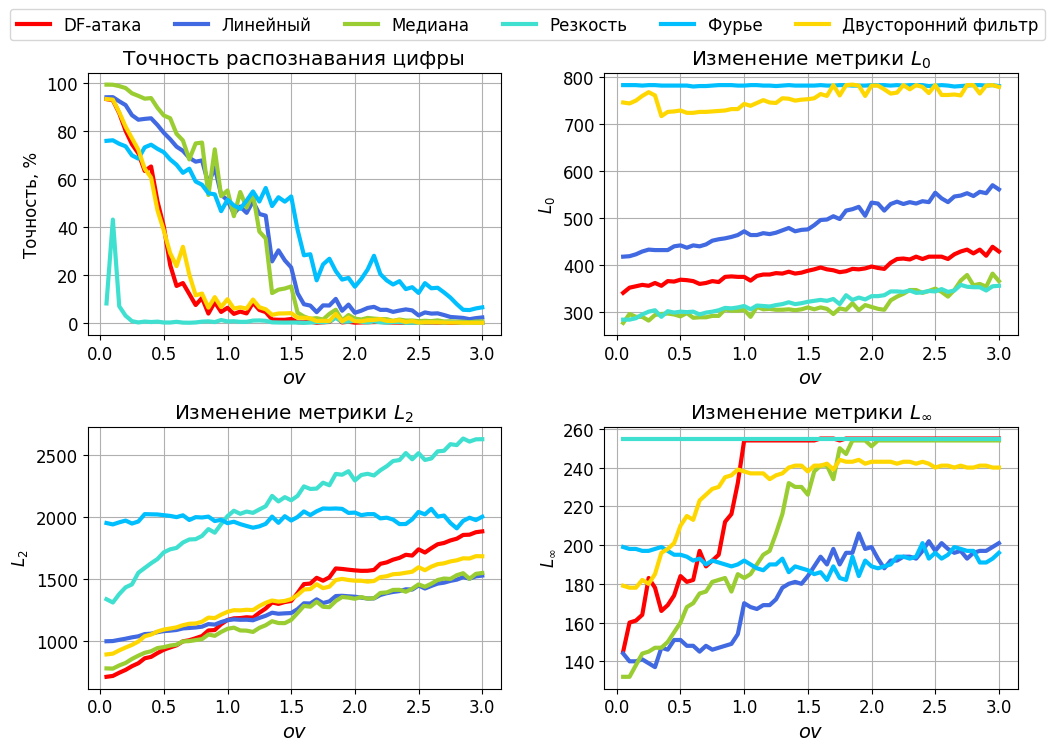

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(2, 2, figsize=(12, 8))

axis[0][0].plot(overshootRange, DF_pred, label = "1", linewidth = 3, color = "red")
axis[0][0].plot(overshootRange, DF_pred_linear, label = "1", linewidth = 3, color = "royalblue")
axis[0][0].plot(overshootRange, DF_pred_median, label = "1", linewidth = 3, color = "yellowgreen")
axis[0][0].plot(overshootRange, DF_pred_sharpe, label = "1", linewidth = 3, color = "turquoise")
axis[0][0].plot(overshootRange, DF_pred_furie, label = "1", linewidth = 3, color = "deepskyblue")
axis[0][0].plot(overshootRange, DF_pred_bil, label = "1", linewidth = 3, color = "gold")
axis[0][0].grid()
axis[0][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][0].set_ylabel("Точность, %")
axis[0][0].set_xlabel("${ov}$", fontsize = 14)
axis[0][0].set_title("Точность распознавания цифры")

lines = []
labels = []

for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    # print(Label)
    lines.extend(Line)
    labels.extend(Label)

axis[0][1].plot(overshootRange, DF_metrics[:, 0], label = "1", linewidth = 3, color = "red")
axis[0][1].plot(overshootRange, DF_metrics_linear[:, 0], label = "1", linewidth = 3, color = "royalblue")
axis[0][1].plot(overshootRange, DF_metrics_median[:, 0], label = "1", linewidth = 3, color = "yellowgreen")
axis[0][1].plot(overshootRange, DF_metrics_sharpe[:, 0], label = "1", linewidth = 3, color = "turquoise")
axis[0][1].plot(overshootRange, DF_metrics_furie[:, 0], label = "1", linewidth = 3, color = "deepskyblue")
axis[0][1].plot(overshootRange, DF_metrics_bil[:, 0], label = "1", linewidth = 3, color = "gold")
axis[0][1].grid()
axis[0][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[0][1].set_ylabel("${L}_{0}$")
axis[0][1].set_xlabel("${ov}$", fontsize = 14)
axis[0][1].set_title("Изменение метрики ${L}_{0}$")

axis[1][0].plot(overshootRange, DF_metrics[:, 2], label = "1", linewidth = 3, color = "red")
axis[1][0].plot(overshootRange, DF_metrics_linear[:, 2], label = "1", linewidth = 3, color = "royalblue")
axis[1][0].plot(overshootRange, DF_metrics_median[:, 2], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][0].plot(overshootRange, DF_metrics_sharpe[:, 2], label = "1", linewidth = 3, color = "turquoise")
axis[1][0].plot(overshootRange, DF_metrics_furie[:, 2], label = "1", linewidth = 3, color = "deepskyblue")
axis[1][0].plot(overshootRange, DF_metrics_bil[:, 2], label = "1", linewidth = 3, color = "gold")
axis[1][0].grid()
axis[1][0].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][0].set_ylabel("${L}_{2}$")
axis[1][0].set_xlabel("${ov}$", fontsize = 14)
axis[1][0].set_title("Изменение метрики ${L}_{2}$")

axis[1][1].plot(overshootRange, DF_metrics[:, 3], label = "1", linewidth = 3, color = "red")
axis[1][1].plot(overshootRange, DF_metrics_linear[:, 3], label = "1", linewidth = 3, color = "royalblue")
axis[1][1].plot(overshootRange, DF_metrics_median[:, 3], label = "1", linewidth = 3, color = "yellowgreen")
axis[1][1].plot(overshootRange, DF_metrics_sharpe[:, 3], label = "1", linewidth = 3, color = "turquoise")
axis[1][1].plot(overshootRange, DF_metrics_furie[:, 3], label = "1", linewidth = 3, color = "deepskyblue")
axis[1][1].plot(overshootRange, DF_metrics_bil[:, 3], label = "1", linewidth = 3, color = "gold")
axis[1][1].grid()
axis[1][1].set_xticks([0.5 * i for i in range(0, 7)])
axis[1][1].set_ylabel("${L}_{∞}$")
axis[1][1].set_xlabel("${ov}$", fontsize = 14)
axis[1][1].set_title("Изменение метрики ${L}_{∞}$")

fig.legend([lines[i] for i in [0,1,2,3,4,5]], ["DF-атака", "Линейный", "Медиана", "Резкость", "Фурье", "Двусторонний фильтр"], loc='upper right', bbox_to_anchor=(0.93, .97), ncol = 6)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.35)
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
DF_results_linear = [0 * i for i in range(0, 10)]
DF_results_sharpe = [0 * i for i in range(0, 10)]

for i in range(0, len(overshootRange)):
  res = model.predict(np.reshape(DF_adv_linear[i], (1, 28, 28, 1)) / 255.)
  DF_results_linear[np.argmax(res[0])] += 1

  res = model.predict(np.reshape(DF_adv_sharpe[i], (1, 28, 28, 1)) / 255.)
  DF_results_sharpe[np.argmax(res[0])] += 1

1/1 [==============================] - 0s 106ms/step


<Figure size 900x400 with 0 Axes>

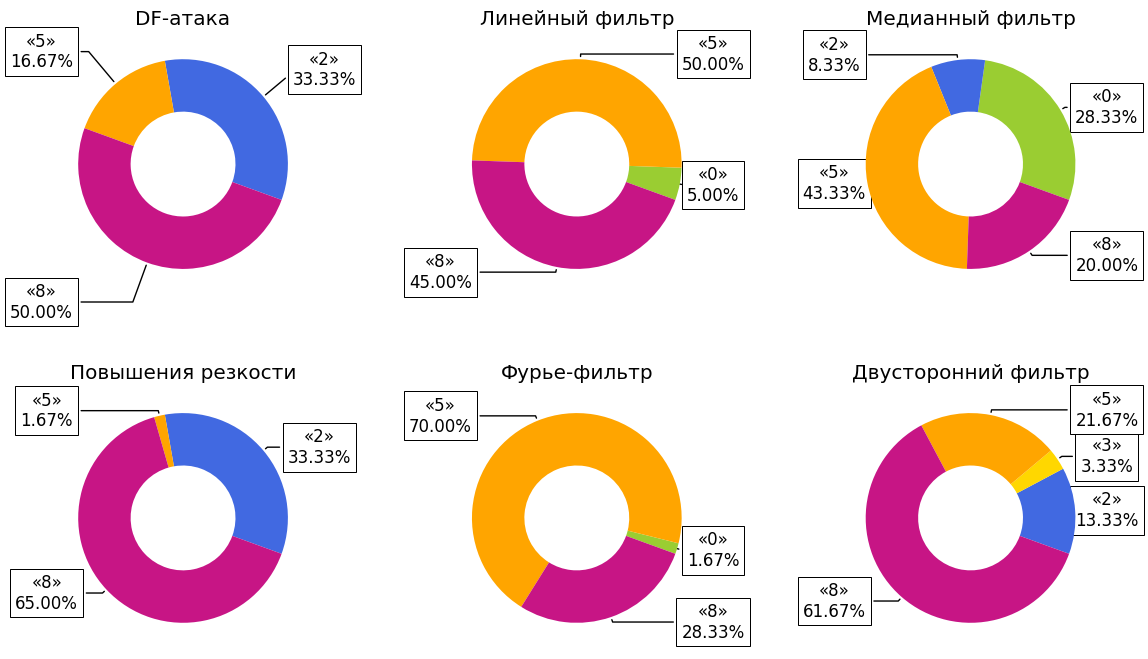

In [ ]:
plt.figure(figsize=[9, 4])
fig, axis = plt.subplots(2, 3, figsize=(15, 8))

cifraLabels = ["«0»", "«1»", "«2»", "«3»", "«4»",
               "«5»", "«6»", "«7»", "«8»", "«9»"]

pieColors = ["yellowgreen", "red", "royalblue", "gold", "darkgrey",
            "orange", "turquoise", "forestgreen", "mediumvioletred", "deepskyblue"]

data_0 = []
label_0 = []
procent_0 = []
color_0 = []
for i in range(0, 10):
  if DF_results[i] != 0:
    data_0.append(DF_results[i])
    label_0.append(cifraLabels[i])
    procent_0.append(DF_results[i] / np.sum(DF_results))
    color_0.append(pieColors[i])

wedges, texts = axis[0][0].pie(data_0, wedgeprops=dict(width=0.5), startangle=-20, colors = color_0 )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0][0].annotate("%s\n%.2f%%" % (label_0[i], procent_0[i] * 100),
                     xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0][0].set_title("DF-атака")

# ----------------------------------------------------------------------------------
data_1 = []
label_1 = []
procent_1 = []
color_1 = []
for i in range(0, 10):
  if DF_results_linear[i] != 0:
    data_1.append(DF_results_linear[i])
    label_1.append(cifraLabels[i])
    procent_1.append(DF_results_linear[i] / np.sum(DF_results_linear))
    color_1.append(pieColors[i])

wedges, texts = axis[0][1].pie(data_1, wedgeprops=dict(width=0.5), startangle=-20, colors = color_1)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0][1].annotate("%s\n%.2f%%" % (label_1[i], procent_1[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0][1].set_title("Линейный фильтр")

# ----------------------------------------------------------------------------------
data_2 = []
label_2 = []
procent_2 = []
color_2 = []
for i in range(0, 10):
  if DF_results_median[i] != 0:
    data_2.append(DF_results_median[i])
    label_2.append(cifraLabels[i])
    procent_2.append(DF_results_median[i] / np.sum(DF_results_median))
    color_2.append(pieColors[i])

wedges, texts = axis[0][2].pie(data_2, wedgeprops=dict(width=0.5), startangle=-20, colors = color_2)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[0][2].annotate("%s\n%.2f%%" % (label_2[i], procent_2[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[0][2].set_title("Медианный фильтр")

# ----------------------------------------------------------------------------------
data_3 = []
label_3 = []
procent_3 = []
color_3 = []
for i in range(0, 10):
  if DF_results_sharpe[i] != 0:
    data_3.append(DF_results_sharpe[i])
    label_3.append(cifraLabels[i])
    procent_3.append(DF_results_sharpe[i] / np.sum(DF_results_sharpe))
    color_3.append(pieColors[i])

wedges, texts = axis[1][0].pie(data_3, wedgeprops=dict(width=0.5), startangle=-20, colors = color_3)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1][0].annotate("%s\n%.2f%%" % (label_3[i], procent_3[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1][0].set_title("Повышения резкости")

# ----------------------------------------------------------------------------------
data_4 = []
label_4 = []
procent_4 = []
color_4 = []
for i in range(0, 10):
  if DF_results_furie[i] != 0:
    data_4.append(DF_results_furie[i])
    label_4.append(cifraLabels[i])
    procent_4.append(DF_results_furie[i] / np.sum(DF_results_furie))
    color_4.append(pieColors[i])

wedges, texts = axis[1][1].pie(data_4, wedgeprops=dict(width=0.5), startangle=-20, colors = color_4)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1][1].annotate("%s\n%.2f%%" % (label_4[i], procent_4[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1][1].set_title("Фурье-фильтр")

# ----------------------------------------------------------------------------------
data_5 = []
label_5 = []
procent_5 = []
color_5 = []
for i in range(0, 10):
  if DF_results_bil[i] != 0:
    data_5.append(DF_results_bil[i])
    label_5.append(cifraLabels[i])
    procent_5.append(DF_results_bil[i] / np.sum(DF_results_bil))
    color_5.append(pieColors[i])

wedges, texts = axis[1][2].pie(data_5, wedgeprops=dict(width=0.5), startangle=-20, colors = color_5)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    axis[1][2].annotate("%s\n%.2f%%" % (label_5[i], procent_5[i] * 100),
                     xy=(x, y), xytext=(1.3*np.sign(x), 1.05*y),
                     horizontalalignment=horizontalalignment, **kw)
axis[1][2].set_title("Двусторонний фильтр")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.35)
plt.rcParams.update({'font.size': 12})
plt.show()

# Функция извлечение шума

In [ ]:
def getDigitTemplate(advImage, mnistDigitsArr, mnistDigitsLabels, numTemplates = 3):
  numSamples = int(len(mnistDigitsArr) / 10) # кол-во примеров на каждый класс цифры
  digitsMetrics = np.zeros((numSamples * 10, 5))
  cifrasAvrgMetrics = np.zeros((10, 5))

  for i in range(numSamples * 10):
    L0, L1, L2, Linf = Metrics(mnistDigitsArr[i], advImage)
    digitsMetrics[i][:] = [i, L0, L1, L2, Linf]
    cifrasAvrgMetrics[mnistDigitsLabels[i]][:] += [mnistDigitsLabels[i], L0, L1, L2, Linf]
  cifrasAvrgMetrics = cifrasAvrgMetrics / numSamples
  sortIndx_1 = cifrasAvrgMetrics[np.lexsort((cifrasAvrgMetrics[:, 4],
                                             cifrasAvrgMetrics[:, 1],
                                             cifrasAvrgMetrics[:, 2],
                                             cifrasAvrgMetrics[:, 3]))]
  searchCifras = []
  searchData = []
  extrNumber = 3
  for i in range(0, extrNumber):
    searchCifras.append(int(sortIndx_1[i][0]))
    searchData.extend(digitsMetrics[numSamples*int(sortIndx_1[i][0]) : numSamples*(int(sortIndx_1[i][0]) + 1)])
  searchData = np.array(searchData)
  sortIndx_2 = np.lexsort((searchData[:, 4],
                           searchData[:, 3],
                           searchData[:, 2],
                           searchData[:, 1]))
  # orig = digitData[int(searchData[ind][0][0])]
  tempOrigs = np.zeros((len(searchCifras), 28, 28))
  tempOrigsMetrics = np.zeros((len(searchCifras), 4))

  for i in range(0, len(searchCifras)):
    counter = 0
    for j in range(0, len(searchData)):
      if mnistDigitsLabels[int(searchData[sortIndx_2][j][0])] == searchCifras[i]:
        tempOrigs[i] += mnistDigitsArr[int(searchData[sortIndx_2][j][0])]
        counter += 1
      if counter == numTemplates:
        tempOrigs[i] = (tempOrigs[i] / numTemplates).astype(np.uint8)
        L0, L1, L2, Linf = Metrics(tempOrigs[i], advImage)
        tempOrigsMetrics[i] = [L0, L1, L2, Linf]
        break
  sortIndx = np.lexsort((tempOrigsMetrics[:, 3],
                         tempOrigsMetrics[:, 0],
                         tempOrigsMetrics[:, 1],
                         tempOrigsMetrics[:, 2]))
  # sortIndx[0] - предполагаемый класс цифры
  # return getDifferenceFromImages(advImg, tempOrigs[ttt[0]], True)
  return sortIndx[0], tempOrigs[sortIndx[0]]

# Подготовка и тестирование комбинаций

In [ ]:
filesMainPath = "/content/drive/MyDrive/Colab Notebooks/AdversarialEducation/testingImagesArrays"
MNIST_10_FGSM = np.load("%s/MNIST_10{FGSM}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MNIST_10_CW = np.load("%s/MNIST_10{CW}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MNIST_10_DF = np.load("%s/MNIST_10{DF}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MNIST_10_NOISE = np.load("%s/MNIST_10{NOISE}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)

MY_10_FGSM = np.load("%s/MY_10{FGSM}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MY_10_CW = np.load("%s/MY_10{CW}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MY_10_DF = np.load("%s/MY_10{DF}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MY_10_NOISE = np.load("%s/MY_10{NOISE}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)

In [ ]:
predDigitModel = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/myModels/cnn_28x28_digits.h5")

In [ ]:
colors = [
    "red",
    "dodgerblue",
    "gold",
    "forestgreen",
    "hotpink",
    "springgreen",
    "mediumorchid",
    "mediumturquoise",
    "lightcoral"
]

In [ ]:
numOrigs_mnist10 = getNumOfExamples(MNIST_10_FGSM)
numOrigs_my10 = getNumOfExamples(MY_10_FGSM)

numFGSM_mnist10 = len(MNIST_10_FGSM) - numOrigs_mnist10
numCW_mnist10 = len(MNIST_10_CW) - numOrigs_mnist10
numDF_mnist10 = len(MNIST_10_DF) - numOrigs_mnist10
numNOISE_mnist10 = len(MNIST_10_NOISE) - numOrigs_mnist10

numFGSM_my10 = len(MY_10_FGSM) - numOrigs_my10
numCW_my10 = len(MY_10_CW) - numOrigs_my10
numDF_my10 = len(MY_10_DF) - numOrigs_my10
numNOISE_my10 = len(MY_10_NOISE) - numOrigs_my10

In [ ]:
(train_data, train_labels), (test_data, test_labels) = datasets.mnist.load_data()

digitCounter = np.zeros(10)
digitCounter[test_labels[0]] += 1
digitData = np.array(test_data[0], ndmin = 3)
digitLabels = np.array(test_labels[0])
numSamples = 200

i = 1
while True:
  i += 1
  if digitCounter[test_labels[i]] < numSamples:
    digitData = np.append(digitData, [test_data[i]], axis = 0)
    digitLabels = np.append(digitLabels, test_labels[i])
    digitCounter[test_labels[i]] += 1
  if np.sum(digitCounter) >= numSamples * 10:
    break

currIndexes = np.argsort(digitLabels)
digitData = digitData[currIndexes]
digitLabels = digitLabels[currIndexes]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def extractDataFromArray(arr, attackClassNumber):
  # В случае, если для извлечения шума используются не оригиналы цифр, а "предполагаемые" оригиналы
  data = []
  for i in range(0, len(arr) - 1, 2):
    indx, tempOrg = getDigitTemplate(arr[i + 1]["adv"], digitData, digitLabels, 5)
    noise = getDifferenceFromImages(arr[i + 1]["adv"], tempOrg)
    temp = [arr[i]["label"], attackClassNumber, noise]
    data.append(temp)
  return data

# Распознавание цифр после обработки атак

In [ ]:
def doSmthng(img):
  # img = FourierFrequencyFiltering(img, 9)
  # img = medianFilter(img)

  # # ↓ ----- Эксперимент с подбором оригиинала ----- ↓
  # indx, tempOrg = getDigitTemplate(img, digitData, digitLabels, 3)
  # noise = getDifferenceFromImages(img, tempOrg)
  # img = getDifferenceFromImages(img, noise)
  # # ↑ -----#---------------------------------#----- ↑
  # # img = FourierFrequencyFiltering(img, 9)

  # # ↓ ----- Эксперимент с усреднением шума ----- ↓
  # indx, tempOrg = getDigitTemplate(img, digitData, digitLabels, 3)
  # noise = getDifferenceFromImages(img, tempOrg)
  # unique_values, counts = np.unique(noise, return_counts=True)
  # rr = 1 if unique_values[0] == 0 else 0
  # s = unique_values[np.argmax(counts[rr:-1]) + 1]
  # bbb = np.where(noise != 0, s, noise)
  # img = getDifferenceFromImages(img, bbb)
  # # ↑ -----#------------------------------#----- ↑
  # img = FourierFrequencyFiltering(img, 9)

  # # ----- Эксперимент № XXX -----
  # img = FourierFrequencyFiltering(img, 9)
  # img = sharpeningFilter(img)
  return img

In [ ]:
MY_10_cifras = []
MY_10_labels = []
MNIST_10_cifras = []
MNIST_10_labels = []

for i in range(0, numOrigs_my10):
  MY_10_cifras.append(doSmthng(MY_10_FGSM[i]["adv"]))
  MY_10_labels.append(MY_10_FGSM[i]["label"])

for i in range(numOrigs_my10, len(MY_10_FGSM)):
  MY_10_cifras.append(doSmthng(MY_10_FGSM[i]["adv"]))
  MY_10_labels.append(MY_10_FGSM[i]["label"])

for i in range(numOrigs_my10, len(MY_10_CW)):
  MY_10_cifras.append(doSmthng(MY_10_CW[i]["adv"]))
  MY_10_labels.append(MY_10_CW[i]["label"])

for i in range(numOrigs_my10, len(MY_10_DF)):
  MY_10_cifras.append(doSmthng(MY_10_DF[i]["adv"]))
  MY_10_labels.append(MY_10_DF[i]["label"])

for i in range(numOrigs_my10, len(MY_10_NOISE)):
  MY_10_cifras.append(doSmthng(MY_10_NOISE[i]["adv"]))
  MY_10_labels.append(MY_10_NOISE[i]["label"])

for i in range(0, numOrigs_mnist10):
  MNIST_10_cifras.append(doSmthng(MNIST_10_FGSM[i]["adv"]))
  MNIST_10_labels.append(MNIST_10_FGSM[i]["label"])

for i in range(numOrigs_mnist10, len(MNIST_10_FGSM)):
  MNIST_10_cifras.append(doSmthng(MNIST_10_FGSM[i]["adv"]))
  MNIST_10_labels.append(MNIST_10_FGSM[i]["label"])

for i in range(numOrigs_mnist10, len(MNIST_10_CW)):
  MNIST_10_cifras.append(doSmthng(MNIST_10_CW[i]["adv"]))
  MNIST_10_labels.append(MNIST_10_CW[i]["label"])

for i in range(numOrigs_mnist10, len(MNIST_10_DF)):
  MNIST_10_cifras.append(doSmthng(MNIST_10_DF[i]["adv"]))
  MNIST_10_labels.append(MNIST_10_DF[i]["label"])

for i in range(numOrigs_mnist10, len(MNIST_10_NOISE)):
  MNIST_10_cifras.append(doSmthng(MNIST_10_NOISE[i]["adv"]))
  MNIST_10_labels.append(MNIST_10_NOISE[i]["label"])

MY_10_cifras = np.array(MY_10_cifras)
MNIST_10_cifras = np.array(MNIST_10_cifras)

imgSize = 28
numChanels = 1
numClasses = 10

MY_10_cifras = np.reshape(MY_10_cifras, (MY_10_cifras.shape[0], imgSize, imgSize, numChanels)) / 255.
MNIST_10_cifras = np.reshape(MNIST_10_cifras, (MNIST_10_cifras.shape[0], imgSize, imgSize, numChanels)) / 255.
MY_10_labels = keras.utils.to_categorical(MY_10_labels, 10)
MNIST_10_labels = keras.utils.to_categorical(MNIST_10_labels, 10)

cifras_data = np.append(MY_10_cifras, MNIST_10_cifras, axis=0)
cifras_labels = np.append(MY_10_labels, MNIST_10_labels, axis=0)

In [ ]:
res_my10_all = predDigitModel.evaluate(MY_10_cifras, MY_10_labels, batch_size=1)
res_my10_org = predDigitModel.evaluate(MY_10_cifras[0 : numOrigs_my10], MY_10_labels[0 : numOrigs_my10], batch_size=1)
length = numOrigs_my10
res_my10_FGSM = predDigitModel.evaluate(MY_10_cifras[length : length + numFGSM_my10], MY_10_labels[length : length + numFGSM_my10], batch_size=1)
length += numFGSM_my10
res_my10_CW = predDigitModel.evaluate(MY_10_cifras[length : length + numCW_my10], MY_10_labels[length : length + numCW_my10], batch_size=1)
length += numCW_my10
res_my10_DF = predDigitModel.evaluate(MY_10_cifras[length : length + numDF_my10], MY_10_labels[length : length + numDF_my10], batch_size=1)
length += numDF_my10
res_my10_NOISE = predDigitModel.evaluate(MY_10_cifras[length : length + numNOISE_my10], MY_10_labels[length : length + numNOISE_my10], batch_size=1)

res_mnist10_all = predDigitModel.evaluate(MNIST_10_cifras, MNIST_10_labels, batch_size=1)
res_mnist10_org = predDigitModel.evaluate(MNIST_10_cifras[0 : numOrigs_mnist10], MNIST_10_labels[0 : numOrigs_mnist10], batch_size=1)
length = numOrigs_mnist10
res_mnist10_FGSM = predDigitModel.evaluate(MNIST_10_cifras[length : length + numFGSM_mnist10], MNIST_10_labels[length : length + numFGSM_mnist10], batch_size=1)
length += numFGSM_mnist10
res_mnist10_CW = predDigitModel.evaluate(MNIST_10_cifras[length : length + numCW_mnist10], MNIST_10_labels[length : length + numCW_mnist10], batch_size=1)
length += numCW_mnist10
res_mnist10_DF = predDigitModel.evaluate(MNIST_10_cifras[length : length + numDF_mnist10], MNIST_10_labels[length : length + numDF_mnist10], batch_size=1)
length += numDF_mnist10
res_mnist10_NOISE = predDigitModel.evaluate(MNIST_10_cifras[length : length + numNOISE_mnist10], MNIST_10_labels[length : length + numNOISE_mnist10], batch_size=1)

600/600 [==============================] - 3s 6ms/step - loss: 2.3956 - accuracy: 0.1083


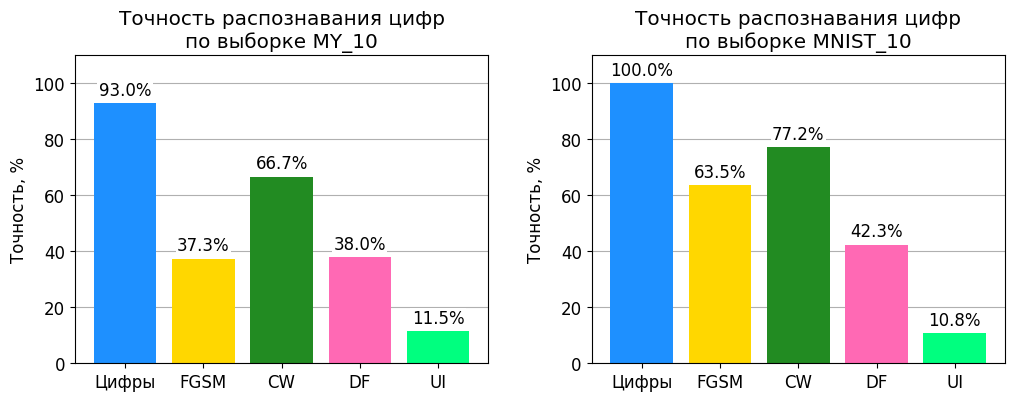

In [ ]:
# height_my10 = [res_my10_org[1], res_my10_FGSM[1], res_my10_CW[1], res_my10_DF[1], res_my10_NOISE[1], res_my10_all[1]]
# height_mnist10 = [res_mnist10_org[1], res_mnist10_FGSM[1], res_mnist10_CW[1], res_mnist10_DF[1], res_mnist10_NOISE[1], res_mnist10_all[1]]
height_my10 = [res_my10_org[1], res_my10_FGSM[1], res_my10_CW[1], res_my10_DF[1], res_my10_NOISE[1]]
height_mnist10 = [res_mnist10_org[1], res_mnist10_FGSM[1], res_mnist10_CW[1], res_mnist10_DF[1], res_mnist10_NOISE[1]]

for i in range(len(height_my10)):
  height_my10[i] = height_my10[i] * 100
for i in range(len(height_mnist10)):
  height_mnist10[i] = height_mnist10[i] * 100

# bars = ('Цифры', 'FGSM', 'CW', 'DF', 'UI', 'All')
bars = ('Цифры', 'FGSM', 'CW', 'DF', 'UI')
y_pos = np.arange(len(bars))
bar = []

fig, axis = plt.subplots(1, 2, figsize=(12, 4))

for i in range(len(height_my10)):
  temp = axis[0].bar(y_pos[i], height_my10[i], color = colors[i + 1], label=bars[i])
  axis[0].bar_label(temp, fmt = "%.1f%%", padding=3, bbox=dict(facecolor='white', edgecolor='none', pad=1))
axis[0].set_ylabel('Точность, %')
axis[0].set_title('Точность распознавания цифр\nпо выборке MY_10')
axis[0].set_ylim(0, 110)
axis[0].set_axisbelow(True)
axis[0].yaxis.grid(True)

for i in range(len(height_my10)):
  temp = axis[1].bar(y_pos[i], height_mnist10[i], color = colors[i + 1], label=bars[i])
  axis[1].bar_label(temp, fmt = "%.1f%%", padding=3, bbox=dict(facecolor='white', edgecolor='none', pad=1))
axis[1].set_ylabel('Точность, %')
axis[1].set_title('Точность распознавания цифр\nпо выборке MNIST_10')
axis[1].set_ylim(0, 110)
axis[1].set_axisbelow(True)
axis[1].yaxis.grid(True)

plt.sca(axis[0])
plt.xticks(y_pos, bars)
plt.sca(axis[1])
plt.xticks(y_pos, bars)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.rcParams.update({'font.size': 12})
# Show graphic
plt.show()

In [ ]:
allMyDigits = []
allMyDigitsFGSM = []
allMyDigitsCW = []
allMyDigitsDF = []
allMyDigitsNOISE = []
allMyDigitsLabels = []

origsAmount = getNumOfExamples(MY_10_FGSM)

for i in range(origsAmount):
  allMyDigits.append(MY_10_FGSM[i]["adv"])
  allMyDigitsLabels.append(MY_10_FGSM[i]["label"])

for i in range(origsAmount, len(MY_10_FGSM)):
  allMyDigits.append(MY_10_FGSM[i]["adv"])
  allMyDigitsFGSM.append(MY_10_FGSM[i]["adv"])
  allMyDigitsLabels.append(MY_10_FGSM[i]["label"])

for i in range(origsAmount, len(MY_10_CW)):
  allMyDigits.append(MY_10_CW[i]["adv"])
  allMyDigitsCW.append(MY_10_CW[i]["adv"])
  allMyDigitsLabels.append(MY_10_CW[i]["label"])

for i in range(origsAmount, len(MY_10_DF)):
  allMyDigits.append(MY_10_DF[i]["adv"])
  allMyDigitsDF.append(MY_10_DF[i]["adv"])
  allMyDigitsLabels.append(MY_10_DF[i]["label"])

for i in range(origsAmount, len(MY_10_NOISE)):
  allMyDigits.append(MY_10_NOISE[i]["adv"])
  allMyDigitsNOISE.append(MY_10_NOISE[i]["adv"])
  allMyDigitsLabels.append(MY_10_NOISE[i]["label"])

allMyDigitsLabels = keras.utils.to_categorical(np.array(allMyDigitsLabels), 10)

# Сравнение методов обработки

In [ ]:
modelAttackRecognition = tf.keras.models.load_model("%s/%s.h5" %
 ("/content/drive/MyDrive/Colab Notebooks/myModels/Сравнение типов обучения",
  "CNN_advDetectModel_2.2"))

In [ ]:
def defence(img):
  tempImg = np.reshape(img, (1, 28, 28, 1)) / 255.
  res = modelAttackRecognition.predict([tempImg])
  attackClass = np.argmax(res[0])
  amount = 0

  if attackClass == 0:
    indx, tempOrg = getDigitTemplate(img, digitData, digitLabels, 3)
    noise = getDifferenceFromImages(img, tempOrg)
    unique_values, counts = np.unique(noise, return_counts=True)
    rr = 1 if unique_values[0] == 0 else 0
    s = unique_values[np.argmax(counts[rr:-1]) + 1]
    bbb = np.where(noise != 0, s, noise)
    img = getDifferenceFromImages(img, bbb)
  elif attackClass == 1 or attackClass == 2:
    img = FourierFrequencyFiltering(img, 9)
  elif attackClass == 3:
    amount = 1

  return img, amount

In [ ]:
my_10_num = [numOrigs_my10, numFGSM_my10, numCW_my10, numDF_my10, numNOISE_my10]
mnist_10_num = [numOrigs_mnist10, numFGSM_mnist10, numCW_mnist10, numDF_mnist10, numNOISE_mnist10]

In [ ]:
MY_10_cifras = []
MNIST_10_cifras = []
MY_10_labels = []
MNIST_10_labels = []
MY_10_cifras_def = []
MNIST_10_cifras_def = []
MY_10_labels_def = []
MNIST_10_labels_def = []
UI_my_counter = 0
UI_mnist_counter = 0

for i in range(0, numOrigs_my10):
  MY_10_cifras.append(MY_10_FGSM[i]["adv"])
  img, amount = defence(MY_10_FGSM[i]["adv"])
  my_10_num[0] -= amount
  UI_my_counter += amount
  MY_10_cifras_def.append(img) if amount == 0 else 0
  MY_10_labels.append(MY_10_FGSM[i]["label"])
  MY_10_labels_def.append(MY_10_FGSM[i]["label"]) if amount == 0 else 0

for i in range(numOrigs_my10, len(MY_10_FGSM)):
  MY_10_cifras.append(MY_10_FGSM[i]["adv"])
  img, amount = defence(MY_10_FGSM[i]["adv"])
  my_10_num[1] -= amount
  UI_my_counter += amount
  MY_10_cifras_def.append(img) if amount == 0 else 0
  MY_10_labels.append(MY_10_FGSM[i]["label"])
  MY_10_labels_def.append(MY_10_FGSM[i]["label"]) if amount == 0 else 0

for i in range(numOrigs_my10, len(MY_10_CW)):
  MY_10_cifras.append(MY_10_CW[i]["adv"])
  img, amount = defence(MY_10_CW[i]["adv"])
  my_10_num[2] -= amount
  UI_my_counter += amount
  MY_10_cifras_def.append(img) if amount == 0 else 0
  MY_10_labels.append(MY_10_CW[i]["label"])
  MY_10_labels_def.append(MY_10_CW[i]["label"]) if amount == 0 else 0

for i in range(numOrigs_my10, len(MY_10_DF)):
  MY_10_cifras.append(MY_10_DF[i]["adv"])
  img, amount = defence(MY_10_DF[i]["adv"])
  my_10_num[3] -= amount
  UI_my_counter += amount
  MY_10_cifras_def.append(img) if amount == 0 else 0
  MY_10_labels.append(MY_10_DF[i]["label"])
  MY_10_labels_def.append(MY_10_DF[i]["label"]) if amount == 0 else 0

for i in range(0, numOrigs_mnist10):
  MNIST_10_cifras.append(MNIST_10_FGSM[i]["adv"])
  img, amount = defence(MNIST_10_FGSM[i]["adv"])
  mnist_10_num[0] -= amount
  UI_mnist_counter += amount
  MNIST_10_cifras_def.append(img) if amount == 0 else 0
  MNIST_10_labels.append(MNIST_10_FGSM[i]["label"])
  MNIST_10_labels_def.append(MNIST_10_FGSM[i]["label"]) if amount == 0 else 0

for i in range(numOrigs_mnist10, len(MNIST_10_FGSM)):
  MNIST_10_cifras.append(MNIST_10_FGSM[i]["adv"])
  img, amount = defence(MNIST_10_FGSM[i]["adv"])
  mnist_10_num[1] -= amount
  UI_mnist_counter += amount
  MNIST_10_cifras_def.append(img) if amount == 0 else 0
  MNIST_10_labels.append(MNIST_10_FGSM[i]["label"])
  MNIST_10_labels_def.append(MNIST_10_FGSM[i]["label"]) if amount == 0 else 0

for i in range(numOrigs_mnist10, len(MNIST_10_CW)):
  MNIST_10_cifras.append(MNIST_10_CW[i]["adv"])
  img, amount = defence(MNIST_10_CW[i]["adv"])
  mnist_10_num[2] -= amount
  UI_mnist_counter += amount
  MNIST_10_cifras_def.append(img) if amount == 0 else 0
  MNIST_10_labels.append(MNIST_10_CW[i]["label"])
  MNIST_10_labels_def.append(MNIST_10_CW[i]["label"]) if amount == 0 else 0

for i in range(numOrigs_mnist10, len(MNIST_10_DF)):
  MNIST_10_cifras.append(MNIST_10_DF[i]["adv"])
  img, amount = defence(MNIST_10_DF[i]["adv"])
  mnist_10_num[3] -= amount
  UI_mnist_counter += amount
  MNIST_10_cifras_def.append(img) if amount == 0 else 0
  MNIST_10_labels.append(MNIST_10_DF[i]["label"])
  MNIST_10_labels_def.append(MNIST_10_DF[i]["label"]) if amount == 0 else 0

MY_10_cifras = np.array(MY_10_cifras)
MY_10_cifras_def = np.array(MY_10_cifras_def)
MNIST_10_cifras_def = np.array(MNIST_10_cifras_def)
MNIST_10_cifras = np.array(MNIST_10_cifras)

imgSize = 28
numChanels = 1
numClasses = 10

MY_10_cifras = np.reshape(MY_10_cifras, (MY_10_cifras.shape[0], imgSize, imgSize, numChanels)) / 255.
MNIST_10_cifras = np.reshape(MNIST_10_cifras, (MNIST_10_cifras.shape[0], imgSize, imgSize, numChanels)) / 255.
MY_10_cifras_def = np.reshape(MY_10_cifras_def, (MY_10_cifras_def.shape[0], imgSize, imgSize, numChanels)) / 255.
MNIST_10_cifras_def = np.reshape(MNIST_10_cifras_def, (MNIST_10_cifras_def.shape[0], imgSize, imgSize, numChanels)) / 255.
MY_10_labels = keras.utils.to_categorical(MY_10_labels, 10)
MNIST_10_labels = keras.utils.to_categorical(MNIST_10_labels, 10)
MY_10_labels_def = keras.utils.to_categorical(MY_10_labels_def, 10)
MNIST_10_labels_def = keras.utils.to_categorical(MNIST_10_labels_def, 10)

1/1 [==============================] - 0s 47ms/step


In [ ]:
print("#---------------# Определяем цифры по атакованным изображениям #---------------#")
res_my10_all = predDigitModel.evaluate(MY_10_cifras, MY_10_labels, batch_size=1)
res_my10_org = predDigitModel.evaluate(MY_10_cifras[0 : numOrigs_my10], MY_10_labels[0 : numOrigs_my10], batch_size=1)
length = numOrigs_my10
res_my10_FGSM = predDigitModel.evaluate(MY_10_cifras[length : length + numFGSM_my10], MY_10_labels[length : length + numFGSM_my10], batch_size=1)
length += numFGSM_my10
res_my10_CW = predDigitModel.evaluate(MY_10_cifras[length : length + numCW_my10], MY_10_labels[length : length + numCW_my10], batch_size=1)
length += numCW_my10
res_my10_DF = predDigitModel.evaluate(MY_10_cifras[length : length + numDF_my10], MY_10_labels[length : length + numDF_my10], batch_size=1)

res_mnist10_all = predDigitModel.evaluate(MNIST_10_cifras, MNIST_10_labels, batch_size=1)
res_mnist10_org = predDigitModel.evaluate(MNIST_10_cifras[0 : numOrigs_mnist10], MNIST_10_labels[0 : numOrigs_mnist10], batch_size=1)
length = numOrigs_mnist10
res_mnist10_FGSM = predDigitModel.evaluate(MNIST_10_cifras[length : length + numFGSM_mnist10], MNIST_10_labels[length : length + numFGSM_mnist10], batch_size=1)
length += numFGSM_mnist10
res_mnist10_CW = predDigitModel.evaluate(MNIST_10_cifras[length : length + numCW_mnist10], MNIST_10_labels[length : length + numCW_mnist10], batch_size=1)
length += numCW_mnist10
res_mnist10_DF = predDigitModel.evaluate(MNIST_10_cifras[length : length + numDF_mnist10], MNIST_10_labels[length : length + numDF_mnist10], batch_size=1)

#---------------# Определяем цифры по атакованным изображениям #---------------#
600/600 [==============================] - 2s 4ms/step - loss: 2.4871 - accuracy: 0.4233


In [ ]:
print("#---------------# Определяем цифры после обработки #---------------#")
res_my10_all_def = predDigitModel.evaluate(MY_10_cifras_def, MY_10_labels_def, batch_size=1)
res_my10_org_def = predDigitModel.evaluate(MY_10_cifras_def[0 : my_10_num[0]], MY_10_labels[0 : my_10_num[0]], batch_size=1)
length = my_10_num[0]
res_my10_FGSM_def = predDigitModel.evaluate(MY_10_cifras_def[length : length + my_10_num[1]], MY_10_labels_def[length : length + my_10_num[1]], batch_size=1)
length += my_10_num[1]
res_my10_CW_def = predDigitModel.evaluate(MY_10_cifras_def[length : length + my_10_num[2]], MY_10_labels_def[length : length + my_10_num[2]], batch_size=1)
length += my_10_num[2]
res_my10_DF_def = predDigitModel.evaluate(MY_10_cifras_def[length : length + my_10_num[3]], MY_10_labels_def[length : length + my_10_num[3]], batch_size=1)

res_mnist10_all_def = predDigitModel.evaluate(MNIST_10_cifras_def, MNIST_10_labels_def, batch_size=1)
res_mnist10_org_def = predDigitModel.evaluate(MNIST_10_cifras_def[0 : mnist_10_num[0]], MNIST_10_labels_def[0 : mnist_10_num[0]], batch_size=1)
length = mnist_10_num[0]
res_mnist10_FGSM_def = predDigitModel.evaluate(MNIST_10_cifras_def[length : length + mnist_10_num[1]], MNIST_10_labels_def[length : length + mnist_10_num[1]], batch_size=1)
length += mnist_10_num[1]
res_mnist10_CW_def = predDigitModel.evaluate(MNIST_10_cifras_def[length : length + mnist_10_num[2]], MNIST_10_labels_def[length : length + mnist_10_num[2]], batch_size=1)
length += mnist_10_num[2]
res_mnist10_DF_def = predDigitModel.evaluate(MNIST_10_cifras_def[length : length + mnist_10_num[3]], MNIST_10_labels_def[length : length + mnist_10_num[3]], batch_size=1)

#---------------# Определяем цифры после обработки #---------------#
599/599 [==============================] - 2s 4ms/step - loss: 0.9627 - accuracy: 0.7279


In [ ]:
height_my10 = [res_my10_org[1], res_my10_FGSM[1], res_my10_CW[1], res_my10_DF[1]]
height_mnist10 = [res_mnist10_org[1], res_mnist10_FGSM[1], res_mnist10_CW[1], res_mnist10_DF[1]]
height_my10_def = [res_my10_org_def[1], res_my10_FGSM_def[1], res_my10_CW_def[1], res_my10_DF_def[1]]
height_mnist10_def = [res_mnist10_org_def[1], res_mnist10_FGSM_def[1], res_mnist10_CW_def[1], res_mnist10_DF_def[1]]

for i in range(len(height_my10)):
  height_my10[i] = height_my10[i] * 100
for i in range(len(height_mnist10)):
  height_mnist10[i] = height_mnist10[i] * 100
for i in range(len(height_my10_def)):
  height_my10_def[i] = height_my10_def[i] * 100
for i in range(len(height_mnist10_def)):
  height_mnist10_def[i] = height_mnist10_def[i] * 100

height_my10 = {"Исходный": (height_my10[0],height_my10[1],height_my10[2],height_my10[3]),
               "Защита": (height_my10_def[0],height_my10_def[1],height_my10_def[2],height_my10_def[3])}
height_mnist10 = {"Исходный": (height_mnist10[0],height_mnist10[1],height_mnist10[2],height_mnist10[3]),
               "Защита": (height_mnist10_def[0],height_mnist10_def[1],height_mnist10_def[2],height_mnist10_def[3])}

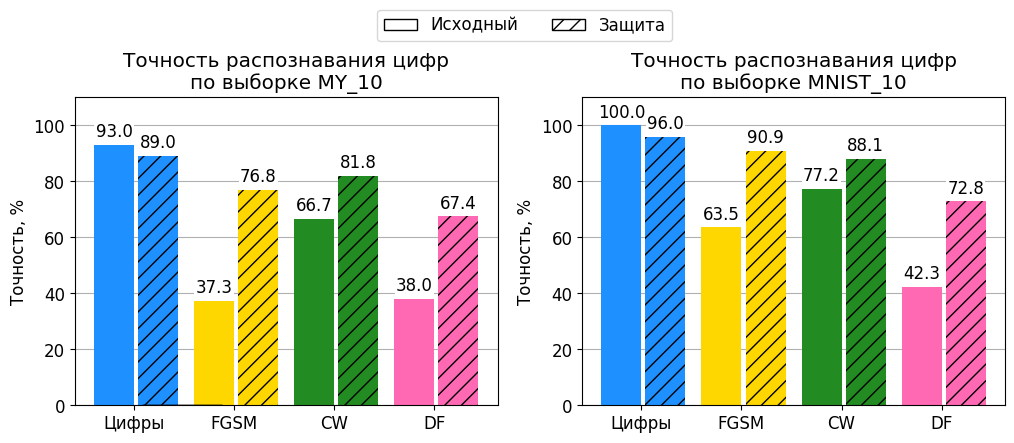

In [ ]:
bars = ('Цифры', 'FGSM', 'CW', 'DF')
hatches = {"Исходный": '', "Защита": '//'}
x = np.arange(len(bars))  # the label locations
width = 0.40  # the width of the bars
multiplier = 0

fig, axis = plt.subplots(1, 2, figsize=(12, 4))

for attribute, measurement in height_my10.items():
  offset = width * multiplier * 1.1
  rects = axis[0].bar(x + offset + width / 2, measurement, width, color = ["dodgerblue", "gold", "forestgreen", "hotpink"], hatch = hatches[attribute])
  axis[0].bar_label(rects, fmt = "%.1f", padding=3, bbox=dict(facecolor='white', edgecolor='none', pad=1), fontsize = 12)
  multiplier += 1
axis[0].set_ylabel('Точность, %')
axis[0].set_title('Точность распознавания цифр\nпо выборке MY_10')
axis[0].set_ylim(0, 110)
axis[0].set_axisbelow(True)
axis[0].yaxis.grid(True)

multiplier = 0
for attribute, measurement in height_mnist10.items():
  offset = width * multiplier * 1.1
  rects = axis[1].bar(x + offset + width / 2, measurement, width, color = ["dodgerblue", "gold", "forestgreen", "hotpink"], hatch = hatches[attribute])
  axis[1].bar_label(rects, fmt = "%.1f", padding=3, bbox=dict(facecolor='white', edgecolor='none', pad=1), fontsize = 12)
  multiplier += 1
axis[1].set_ylabel('Точность, %')
axis[1].set_title('Точность распознавания цифр\nпо выборке MNIST_10')
axis[1].set_ylim(0, 110)
axis[1].set_axisbelow(True)
axis[1].yaxis.grid(True)

dummy_bars = []
for b_idx in [0, 1]:
    dummy_bars.append(axis[0].bar(width * multiplier * 1.1, 0, color = "none", edgecolor='k', hatch = '' if b_idx == 0 else '//'))
barsbars = axis[0].get_lines()

# legend1 = fig.legend([lines[i] for i in [0,1]], ["adversarial", "perturbation"], loc='upper right', bbox_to_anchor=(0.45, 1.07), ncol = 2)
legend2 = fig.legend(handles = [dummy_bars[i] for i in [0,1]],
                     labels = ["Исходный", "Защита"],
                     loc='upper left',
                     bbox_to_anchor=(0.37, 1.12),
                     ncol = 2)
# fig.add_artist(legend1)

plt.sca(axis[0])
plt.xticks(x + width, bars)
plt.sca(axis[1])
plt.xticks(x + width, bars)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
plt.rcParams.update({'font.size': 12})
plt.show()

# Фурье фильтр

In [ ]:
CW_furie = []
DF_firue = []
NOISE_firue = []
FGSM_firue = []
Cifra_furie = []
radiuses = list(range(40))

for rad in radiuses:
  print("Radius: %d" % rad)
  temp = []
  for i in range(0, origsAmount):
    temp.append(FourierFrequencyFiltering(allMyDigits[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[0:origsAmount], batch_size=1)
  Cifra_furie.append(tempRes[1] * 100)
  maxLen = 0

  temp = []
  for i in range(0, len(allMyDigitsFGSM)):
    temp.append(FourierFrequencyFiltering(allMyDigitsFGSM[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsFGSM)], batch_size=1)
  FGSM_firue.append(tempRes[1] * 100)
  maxLen += len(allMyDigitsFGSM)

  temp = []
  for i in range(0, len(allMyDigitsCW)):
    temp.append(FourierFrequencyFiltering(allMyDigitsCW[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsCW)], batch_size=1)
  CW_furie.append(tempRes[1] * 100)
  maxLen += len(allMyDigitsCW)

  temp = []
  for i in range(0, len(allMyDigitsDF)):
    temp.append(FourierFrequencyFiltering(allMyDigitsDF[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen +len(allMyDigitsDF)], batch_size=1)
  DF_firue.append(tempRes[1] * 100)

  temp = []
  for i in range(0, len(allMyDigitsNOISE)):
    temp.append(FourierFrequencyFiltering(allMyDigitsNOISE[i], rad))
  temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
  temp = temp / 255.
  tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen +len(allMyDigitsNOISE)], batch_size=1)
  NOISE_firue.append(tempRes[1] * 100)

Radius: 0
600/600 [==============================] - 2s 4ms/step - loss: 3.3622 - accuracy: 0.1000
Radius: 1
600/600 [==============================] - 4s 6ms/step - loss: 2.3659 - accuracy: 0.1000
Radius: 2
600/600 [==============================] - 2s 4ms/step - loss: 2.3731 - accuracy: 0.1000
Radius: 3
600/600 [==============================] - 2s 4ms/step - loss: 2.3737 - accuracy: 0.1017
Radius: 4
600/600 [==============================] - 2s 4ms/step - loss: 2.4207 - accuracy: 0.1217
Radius: 5
600/600 [==============================] - 4s 6ms/step - loss: 2.3751 - accuracy: 0.1050
Radius: 6
600/600 [==============================] - 3s 5ms/step - loss: 2.3620 - accuracy: 0.1033
Radius: 7
600/600 [==============================] - 3s 5ms/step - loss: 2.3526 - accuracy: 0.1100
Radius: 8
600/600 [==============================] - 2s 4ms/step - loss: 2.3363 - accuracy: 0.1200
Radius: 9
600/600 [==============================] - 2s 4ms/step - loss: 2.3491 - accuracy: 0.1283
Radius: 10

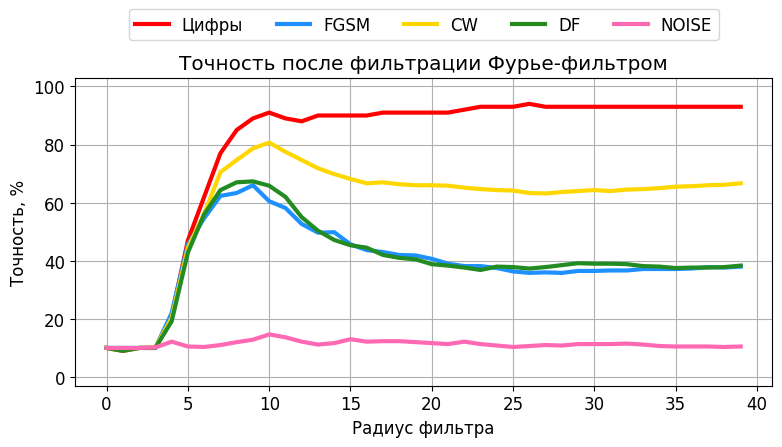

In [ ]:
plt.figure(figsize=[9, 4])
plt.plot(radiuses, Cifra_furie, label = "Цифры", linewidth = 3, color = colors[0])
plt.plot(radiuses, FGSM_firue, label = "FGSM", linewidth = 3, color = colors[1])
plt.plot(radiuses, CW_furie, label = "CW", linewidth = 3, color = colors[2])
plt.plot(radiuses, DF_firue, label = "DF", linewidth = 3, color = colors[3])
plt.plot(radiuses, NOISE_firue, label = "NOISE", linewidth = 3, color = colors[4])
plt.grid()
plt.ylabel("Точность, %")
plt.xlabel("Радиус фильтра")
plt.ylim(-3, 103)
plt.title("Точность после фильтрации Фурье-фильтром")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5)

plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
print(radiuses[9])

9


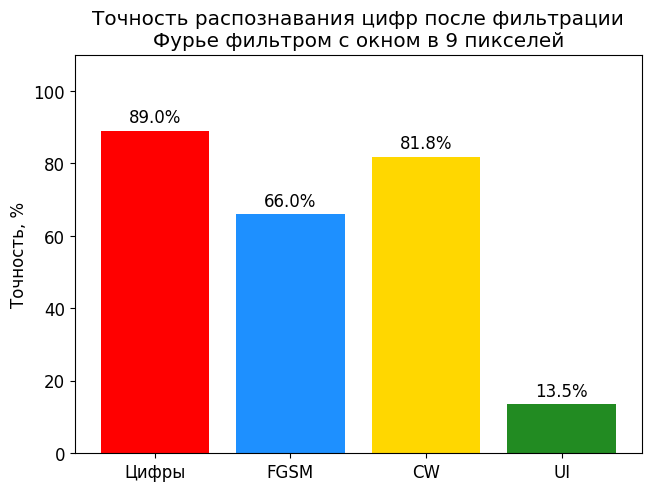

In [ ]:
height = [Cifra_furie[9], FGSM_firue[9], CW_furie[9], NOISE_firue[9]]
for i in range(len(height)):
  height[i] = height[i] * 100
bars = ('Цифры', 'FGSM', 'CW', 'UI')
y_pos = np.arange(len(bars))
bar = []

fig, ax = plt.subplots(layout='constrained')

for i in range(len(height)):
  temp = ax.bar(y_pos[i], height[i], color = colors[i], label=bars[i])
  ax.bar_label(temp, fmt = "%.1f%%", padding=3)

# Create names on the x-axis
plt.xticks(y_pos, bars)

ax.set_ylabel('Точность, %')
ax.set_title("Точность распознавания цифр после фильтрации\nФурье фильтром с окном в 9 пикселей")
plt.xticks(y_pos, bars)
ax.set_ylim(0, 110)
plt.rcParams.update({'font.size': 12})
# Show graphic
plt.show()

# Медианный фильтр

In [ ]:
CW_mediana = []
NOISE_mediana = []
FGSM_mediana = []
Cifra_mediana = []
sizeA, sizeB = 7, 7

temp = []
for i in range(0, origsAmount):
  temp.append(medianFilter(allMyDigits[i], sizeA, sizeB))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[0:origsAmount], batch_size=1)
Cifra_mediana.append(tempRes[1] * 100)
maxLen = 0

temp = []
for i in range(0, len(allMyDigitsFGSM)):
  temp.append(medianFilter(allMyDigitsFGSM[i], sizeA, sizeB))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsFGSM)], batch_size=1)
FGSM_mediana.append(tempRes[1] * 100)
maxLen += len(allMyDigitsFGSM)

temp = []
for i in range(0, len(allMyDigitsCW)):
  temp.append(medianFilter(allMyDigitsCW[i], sizeA, sizeB))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsCW)], batch_size=1)
CW_mediana.append(tempRes[1] * 100)
maxLen += len(allMyDigitsCW)

temp = []
for i in range(0, len(allMyDigitsNOISE)):
  temp.append(medianFilter(allMyDigitsNOISE[i], sizeA, sizeB))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen +len(allMyDigitsNOISE)], batch_size=1)
NOISE_mediana.append(tempRes[1] * 100)

400/400 [==============================] - 2s 6ms/step - loss: 2.4815 - accuracy: 0.1200


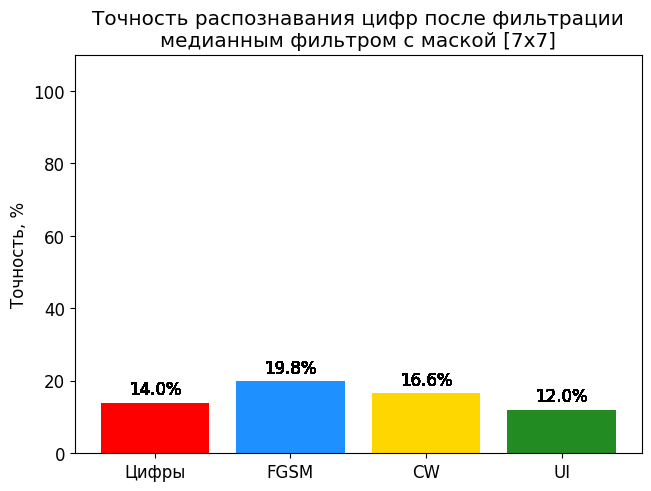

In [ ]:
height = [Cifra_mediana, FGSM_mediana, CW_mediana, NOISE_mediana]
for i in range(len(height)):
  height[i] = height[i] * 100
bars = ('Цифры', 'FGSM', 'CW', 'UI')
y_pos = np.arange(len(bars))
bar = []

fig, ax = plt.subplots(layout='constrained')

for i in range(len(height)):
  temp = ax.bar(y_pos[i], height[i], color = colors[i], label=bars[i])
  ax.bar_label(temp, fmt = "%.1f%%", padding=3)

# Create names on the x-axis
plt.xticks(y_pos, bars)

ax.set_ylabel('Точность, %')
ax.set_title("Точность распознавания цифр после фильтрации\nмедианным фильтром с маской [%dx%d]" % (sizeA, sizeB))
plt.xticks(y_pos, bars)
ax.set_ylim(0, 110)
plt.rcParams.update({'font.size': 12})
# Show graphic
plt.show()

# Фильтр повышения резкости

In [ ]:
CW_sharpening = []
NOISE_sharpening = []
FGSM_sharpening = []
Cifra_sharpening = []

temp = []
for i in range(0, origsAmount):
  temp.append(sharpeningFilter(allMyDigits[i]))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[0:origsAmount], batch_size=1)
Cifra_sharpening.append(tempRes[1] * 100)
maxLen = 0

temp = []
for i in range(0, len(allMyDigitsFGSM)):
  temp.append(sharpeningFilter(allMyDigitsFGSM[i]))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsFGSM)], batch_size=1)
FGSM_sharpening.append(tempRes[1] * 100)
maxLen += len(allMyDigitsFGSM)

temp = []
for i in range(0, len(allMyDigitsCW)):
  temp.append(sharpeningFilter(allMyDigitsCW[i]))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsCW)], batch_size=1)
CW_sharpening.append(tempRes[1] * 100)
maxLen += len(allMyDigitsCW)

temp = []
for i in range(0, len(allMyDigitsNOISE)):
  temp.append(sharpeningFilter(allMyDigitsNOISE[i]))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen +len(allMyDigitsNOISE)], batch_size=1)
NOISE_sharpening.append(tempRes[1] * 100)

400/400 [==============================] - 2s 4ms/step - loss: 2.4143 - accuracy: 0.0825


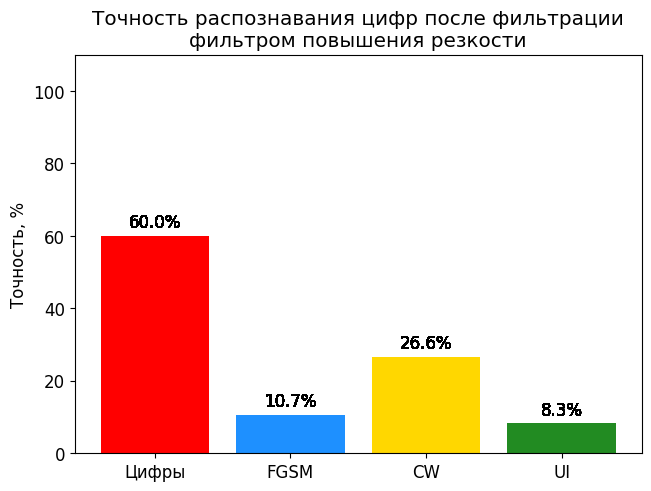

In [ ]:
height = [Cifra_sharpening, FGSM_sharpening, CW_sharpening, NOISE_sharpening]
for i in range(len(height)):
  height[i] = height[i] * 100
bars = ('Цифры', 'FGSM', 'CW', 'UI')
y_pos = np.arange(len(bars))
bar = []

fig, ax = plt.subplots(layout='constrained')

for i in range(len(height)):
  temp = ax.bar(y_pos[i], height[i], color = colors[i], label=bars[i])
  ax.bar_label(temp, fmt = "%.1f%%", padding=3)

# Create names on the x-axis
plt.xticks(y_pos, bars)

ax.set_ylabel('Точность, %')
ax.set_title("Точность распознавания цифр после фильтрации\nфильтром повышения резкости")
plt.xticks(y_pos, bars)
ax.set_ylim(0, 110)
plt.rcParams.update({'font.size': 12})
# Show graphic
plt.show()

# Удаление извлеченного шума

In [ ]:
def aaa(advImg, digitData, digitLabels):
  numSamples = int(len(digitData) / 10)
  digitsMetrics = np.zeros((numSamples * 10, 5))
  cifrasAvrgMetrics = np.zeros((10, 5))
  for i in range(0, numSamples * 10):
    L0, L1, L2, Linf = Metrics(digitData[i], advImg)
    digitsMetrics[i][:] = [i, L0, L1, L2, Linf]
    cifrasAvrgMetrics[digitLabels[i]][:] += [digitLabels[i], L0, L1, L2, Linf]
  cifrasAvrgMetrics = cifrasAvrgMetrics / numSamples

  ind1 = cifrasAvrgMetrics[np.lexsort((cifrasAvrgMetrics[:, 4],
                              cifrasAvrgMetrics[:, 1],
                              cifrasAvrgMetrics[:, 2],
                              cifrasAvrgMetrics[:, 3]))]

  searchCifras = []
  searchData = []
  extrNumber = 3
  for i in range(0, extrNumber):
    searchCifras.append(int(ind1[i][0]))
    searchData.extend(digitsMetrics[numSamples * int(ind1[i][0]):numSamples * (int(ind1[i][0]) + 1)])
  searchData = np.array(searchData)

  ind = np.lexsort((searchData[:, 4], searchData[:, 3], searchData[:, 2], searchData[:, 1]))
  # orig = digitData[int(searchData[ind][0][0])]
  tempOrigs = np.zeros((len(searchCifras), 28, 28))
  tempOrigsMetrics = np.zeros((len(searchCifras), 4))

  for i in range(0, len(searchCifras)):
    counter = 0
    for j in range(0, len(searchData)):
      if digitLabels[int(searchData[ind][j][0])] == searchCifras[i]:
        tempOrigs[i] += digitData[int(searchData[ind][j][0])]
        counter += 1
      if counter == extrNumber:
        tempOrigs[i] = (tempOrigs[i] / extrNumber).astype(np.uint8)
        L0, L1, L2, Linf = Metrics(tempOrigs[i], advImg)
        tempOrigsMetrics[i] = [L0, L1, L2, Linf]
        break
  ttt = np.lexsort((tempOrigsMetrics[:, 3],
                    tempOrigsMetrics[:, 0],
                    tempOrigsMetrics[:, 1],
                    tempOrigsMetrics[:, 2]))
  # print("%d - Optimal is «%d» (indx %d)" % (origDigitLabel, searchCifras[ttt[0]], ttt[0]))
  return tempOrigs[ttt[0]]

In [ ]:
(train_data, train_labels), (test_data, test_labels) = datasets.mnist.load_data()

digitCounter = np.zeros(10)
digitCounter[test_labels[0]] += 1
digitData = np.array(test_data[0], ndmin = 3)
digitLabels = np.array(test_labels[0])
numSamples = 200

i = 1
while True:
  i += 1
  if digitCounter[test_labels[i]] < numSamples:
    digitData = np.append(digitData, [test_data[i]], axis = 0)
    digitLabels = np.append(digitLabels, test_labels[i])
    digitCounter[test_labels[i]] += 1
  if np.sum(digitCounter) >= numSamples * 10:
    break

currIndexes = np.argsort(digitLabels)
digitData = digitData[currIndexes]
digitLabels = digitLabels[currIndexes]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
CW_delete = []
NOISE_delete = []
FGSM_delete= []
Cifra_delete = []

temp = []
for i in range(0, origsAmount):
  tempOrig = aaa(allMyDigits[i], digitData, digitLabels)
  noise = getDifferenceFromImages(allMyDigits[i], tempOrig, True)
  unique_values, counts = np.unique(noise, return_counts=True)
  rr = 1 if unique_values[0] == 0 else 0
  s = unique_values[np.argmax(counts[rr:-1]) + 1]
  bbb = np.where(noise != 0, s, noise)
  img = getDifferenceFromImages(allMyDigits[i], bbb)
  temp.append(FourierFrequencyFiltering(img, 9))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[0:origsAmount], batch_size=1)
Cifra_delete.append(tempRes[1] * 100)
maxLen = 0

temp = []
for i in range(0, len(allMyDigitsFGSM)):
  tempOrig = aaa(allMyDigitsFGSM[i], digitData, digitLabels)
  noise = getDifferenceFromImages(allMyDigitsFGSM[i], tempOrig, True)
  unique_values, counts = np.unique(noise, return_counts=True)
  rr = 1 if unique_values[0] == 0 else 0
  s = unique_values[np.argmax(counts[rr:-1]) + 1]
  bbb = np.where(noise != 0, s, noise)
  img = getDifferenceFromImages(allMyDigitsFGSM[i], bbb)
  temp.append(FourierFrequencyFiltering(img, 9))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsFGSM)], batch_size=1)
FGSM_delete.append(tempRes[1] * 100)
maxLen += len(allMyDigitsFGSM)

temp = []
for i in range(0, len(allMyDigitsCW)):
  tempOrig = aaa(allMyDigitsCW[i], digitData, digitLabels)
  noise = getDifferenceFromImages(allMyDigitsCW[i], tempOrig, True)
  unique_values, counts = np.unique(noise, return_counts=True)
  rr = 1 if unique_values[0] == 0 else 0
  s = unique_values[np.argmax(counts[rr:-1]) + 1]
  bbb = np.where(noise != 0, s, noise)
  img = getDifferenceFromImages(allMyDigitsCW[i], bbb)
  temp.append(FourierFrequencyFiltering(img, 9))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen + len(allMyDigitsCW)], batch_size=1)
CW_delete.append(tempRes[1] * 100)
maxLen += len(allMyDigitsCW)

temp = []
for i in range(0, len(allMyDigitsNOISE)):
  tempOrig = aaa(allMyDigitsNOISE[i], digitData, digitLabels)
  noise = getDifferenceFromImages(allMyDigitsNOISE[i], tempOrig, True)
  unique_values, counts = np.unique(noise, return_counts=True)
  rr = 1 if unique_values[0] == 0 else 0
  s = unique_values[np.argmax(counts[rr:-1]) + 1]
  bbb = np.where(noise != 0, s, noise)
  img = getDifferenceFromImages(allMyDigitsNOISE[i], bbb)
  temp.append(FourierFrequencyFiltering(img, 9))
temp = np.reshape(np.array(temp), (np.array(temp).shape[0], 28, 28, 1))
temp = temp / 255.
tempRes = predDigitModel.evaluate(temp, allMyDigitsLabels[origsAmount + maxLen : origsAmount + maxLen +len(allMyDigitsNOISE)], batch_size=1)
NOISE_delete.append(tempRes[1] * 100)

400/400 [==============================] - 2s 5ms/step - loss: 2.6750 - accuracy: 0.1400


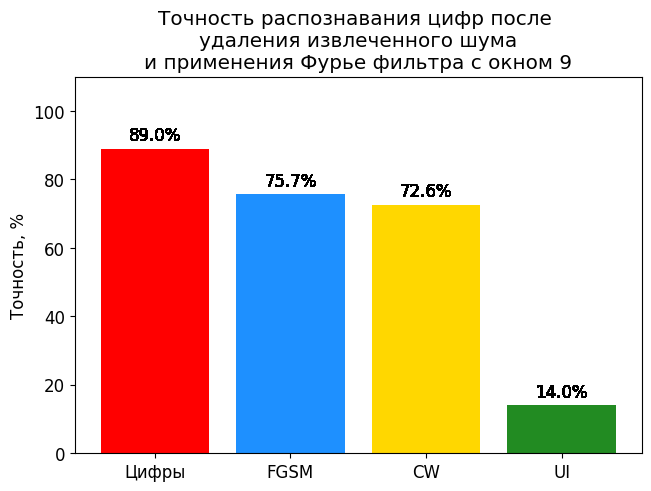

In [ ]:
height = [Cifra_delete, FGSM_delete, CW_delete, NOISE_delete]
for i in range(len(height)):
  height[i] = height[i] * 100
bars = ('Цифры', 'FGSM', 'CW', 'UI')
y_pos = np.arange(len(bars))
bar = []

fig, ax = plt.subplots(layout='constrained')

for i in range(len(height)):
  temp = ax.bar(y_pos[i], height[i], color = colors[i], label=bars[i])
  ax.bar_label(temp, fmt = "%.1f%%", padding=3)

# Create names on the x-axis
plt.xticks(y_pos, bars)

ax.set_ylabel('Точность, %')
ax.set_title("Точность распознавания цифр после \nудаления извлеченного шума\nи применения Фурье фильтра с окном 9")
plt.xticks(y_pos, bars)
ax.set_ylim(0, 110)
plt.rcParams.update({'font.size': 12})
# Show graphic
plt.show()

# Эксперименты

In [ ]:
img = MNIST_10_FGSM[447]["adv"]

In [ ]:
img = MNIST_10_CW[347]["adv"]

In [ ]:
tempOrig = aaa(img, digitData, digitLabels)
noise = getDifferenceFromImages(img, tempOrig, True)
unique_values, counts = np.unique(noise, return_counts=True)
rr = 1 if unique_values[0] == 0 else 0
s = unique_values[np.argmax(counts[rr:-1]) + 1]
bbb = np.where(noise != 0, s, noise)
ttt = getDifferenceFromImages(img, bbb)
# lol = medianFilter(ttt, 9)
lol = FourierFrequencyFiltering(ttt, 9)

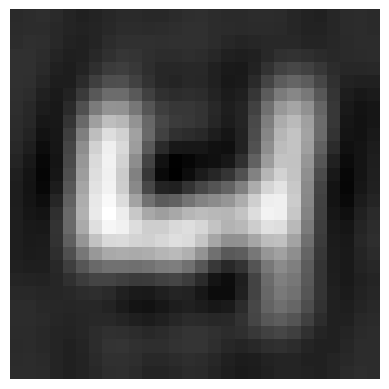

In [ ]:
# np.reshape(np.array([x for x in np.reshape(abs(G), (1, -1))[0]]), (P, Q))
# np.reshape(np.array([math.log10(x) for x in np.reshape(abs(F), (1, -1))[0]]), (P, Q))
# FourierFrequencyFiltering(img, 15), cmap = 'gray'
# medianFilter(img, 7, 7), cmap = 'gray'
# sharpeningFilter
# linearFilter

plt.imshow(
    lol, cmap = 'gray', vmin=0, vmax=255
    )
plt.axis('off')
plt.savefig('temp.png', bbox_inches='tight', pad_inches=0)

1/1 [==============================] - 0s 24ms/step


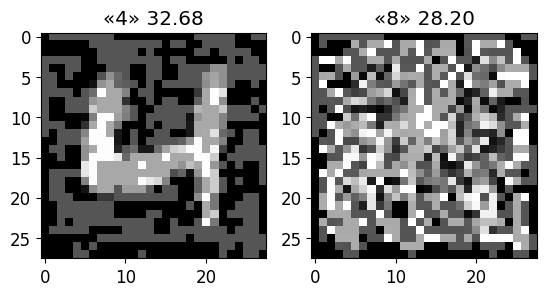

In [ ]:
res = predDigitModel.predict(img.reshape((1, 28, 28, 1)) / 255.)
filtered = sharpeningFilter(img)
res_1 = predDigitModel.predict(filtered.reshape((1, 28, 28, 1)) / 255.)

figure, axis = plt.subplots(1, 2)
axis[0].imshow(img, cmap = "gray", vmin = 0, vmax = 255)
axis[0].set_title("«%d» %.2f" % (np.argmax(res), res[0][np.argmax(res)] * 100))
axis[1].imshow(filtered, cmap = "gray", vmin = 0, vmax = 255)
axis[1].set_title("«%d» %.2f" % (np.argmax(res_1), res_1[0][np.argmax(res_1)] * 100))
plt.show()

# Просмотр картинок

In [ ]:
filesMainPath = "/content/drive/MyDrive/Colab Notebooks/AdversarialEducation/testingImagesArrays"
MNIST_10_FGSM = np.load("%s/MNIST_10{FGSM}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MNIST_10_CW = np.load("%s/MNIST_10{CW}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MNIST_10_DF = np.load("%s/MNIST_10{DF}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)
MNIST_10_NOISE = np.load("%s/MNIST_10{NOISE}_cifraExamplesForTests.npy" % filesMainPath, allow_pickle=True)

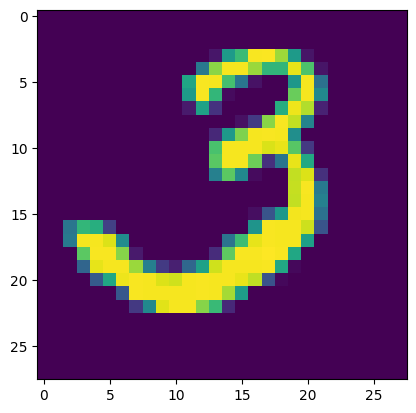

In [ ]:
indx = 33
origImg = MNIST_10_FGSM[indx]["adv"]
plt.imshow(origImg)

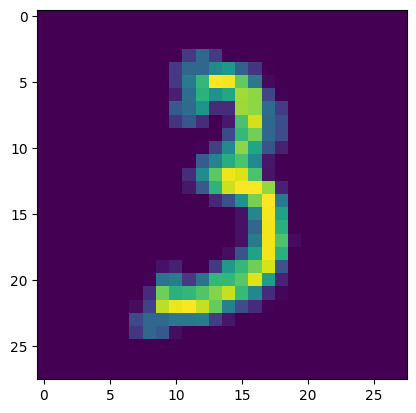

In [ ]:
ind, tempOrg = getDigitTemplate(MNIST_10_FGSM[300 + indx]["adv"], digitData, digitLabels, 3)
plt.imshow(tempOrg)
png = Image.fromarray(preparePicture(tempOrg, 4))
png.save("%s/tempOrg.png" % (path))

In [ ]:
ind, tempOrg = getDigitTemplate(MNIST_10_FGSM[300 + indx]["adv"], digitData, digitLabels, 3)
noise = getDifferenceFromImages(MNIST_10_FGSM[300 + indx]["adv"], tempOrg)
png = Image.fromarray(preparePicture(noise, 4))
png.save("%s/noise.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))
unique_values, counts = np.unique(noise, return_counts=True)
rr = 1 if unique_values[0] == 0 else 0
s = unique_values[np.argmax(counts[rr:-1]) + 1]
bbb = np.where(noise != 0, s, noise)
png = Image.fromarray(preparePicture(bbb, 4))
png.save("%s/median_noise.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))
img = getDifferenceFromImages(MNIST_10_FGSM[300 + indx]["adv"], bbb)
png = Image.fromarray(preparePicture(img, 4))
png.save("%s/diff.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))

In [ ]:
print(counts)
print(unique_values)
print(s)

[280   1   5   2   2   4   3   1   1   2   1   3   3   3   1   4   1   1
   1   3   1   3   2   2   1   4   4   2   2   1   1   1   4   6   1   3
   1   2   2   5   2 272   1   2   1   1   3   1   2   2   1   3   1   2
   1   1   2   1   2   2   3   1   2   1   2   1   1   1   1   1   2   1
   1   1   1   3   1   2   1   1   1   2   3   1   1   3   3   1   1   1
   1   1   1   1   2   1   2   2   1   2   1   1   1   1   1   1   2   1
   2   1   2   1   3   1   2   1   2   8   4   3   1   2   2   1   1   1
   1   1   3]
[  0   1   2   3   4   5   6   7   9  10  11  12  13  14  16  17  18  19
  21  24  25  26  27  28  30  31  32  33  35  36  40  41  42  43  45  46
  48  49  53  55  56  58  60  61  62  63  65  68  69  70  72  73  74  76
  78  79  80  81  83  84  85  86  91  92  93  94  95  98  99 103 106 107
 108 109 110 112 114 116 117 118 119 123 128 129 131 133 134 135 138 139
 141 142 145 146 147 148 151 153 154 155 159 160 161 162 165 166 167 170
 173 175 177 178 186 188 189 190 191 

In [ ]:
def prepare(img, orig, scaling = 4, numChanels = 3):
  origSize_X = len(img)
  origSize_Y = len(img[0])
  tempImg = np.zeros((origSize_X * scaling, origSize_Y * scaling, numChanels))
  for i in range(0, origSize_X):
    for j in range(0, origSize_Y):
      if orig[i][j] != img[i][j] and orig[i][j] != 0:
        tempImg[(i * scaling) : (i * scaling + scaling),
         (j * scaling) : (j * scaling + scaling)] = (img[i][j], 0, 0)
      else:
        tempImg[(i * scaling) : (i * scaling + scaling),
         (j * scaling) : (j * scaling + scaling)] = img[i][j]
  return tempImg

In [ ]:
noise_1 = getDifferenceFromImages(MNIST_10_FGSM[400 + indx]["adv"], origImg)
noise_2 = getDifferenceFromImages(MNIST_10_CW[600 + indx]["adv"], origImg)

png = Image.fromarray(preparePicture(noise_1, 4))
png.save("%s/noise_1.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))

png = Image.fromarray(preparePicture(noise_2, 4))
png.save("%s/noise_2.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))

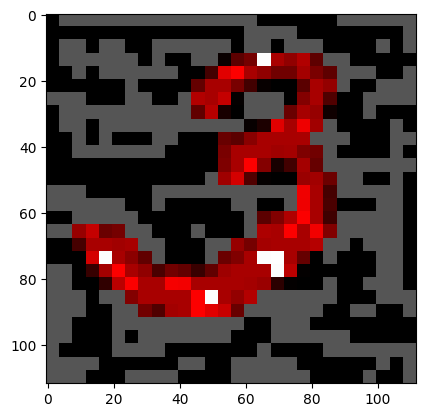

In [ ]:
atk_1 = prepare(MNIST_10_FGSM[400 + indx]["adv"], origImg)
atk_2 = prepare(MNIST_10_CW[600 + indx]["adv"], origImg)

plt.imshow(atk_1.astype(np.uint8), vmax = 255, vmin = 0)

png = Image.fromarray(atk_1.astype(np.uint8))
png.save("%s/atk_1.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))

png = Image.fromarray(atk_2.astype(np.uint8))
png.save("%s/atk_2.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))

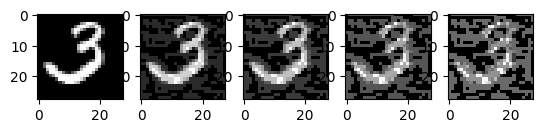

eps : 0.100
eps : 0.150
eps : 0.250
eps : 0.350


In [ ]:
figure, axis = plt.subplots(1, 5)
axis[0].imshow(origImg, cmap='gray', vmin=0, vmax=255)
axis[1].imshow(MNIST_10_FGSM[200 + indx]["adv"], cmap='gray', vmin=0, vmax=255)
axis[2].imshow(MNIST_10_FGSM[300 + indx]["adv"], cmap='gray', vmin=0, vmax=255)
axis[3].imshow(MNIST_10_FGSM[400 + indx]["adv"], cmap='gray', vmin=0, vmax=255)
axis[4].imshow(MNIST_10_FGSM[600 + indx]["adv"], cmap='gray', vmin=0, vmax=255)

plt.show()

print(MNIST_10_FGSM[200]["info"])
print(MNIST_10_FGSM[300]["info"])
print(MNIST_10_FGSM[400]["info"])
print(MNIST_10_FGSM[600]["info"])

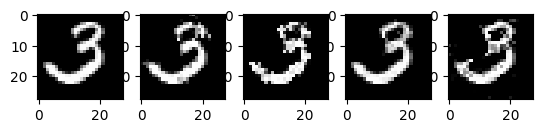

coef: 4.00 | steps: 7 | rate: 1.75 | targeted: 0
coef: 1.50 | steps: 7 | rate: 1.30 | targeted: 0
coef: 0.05 | steps: 5 | rate: 0.10 | targeted: 0
coef: 0.37 | steps: 4 | rate: 1.05 | targeted: 1


In [ ]:
figure, axis = plt.subplots(1, 5)
axis[0].imshow(origImg, cmap='gray', vmin=0, vmax=255)
axis[1].imshow(MNIST_10_CW[200 + indx]["adv"], cmap='gray', vmin=0, vmax=255)
axis[2].imshow(MNIST_10_CW[300 + indx]["adv"], cmap='gray', vmin=0, vmax=255)
axis[3].imshow(MNIST_10_CW[400 + indx]["adv"], cmap='gray', vmin=0, vmax=255)
axis[4].imshow(MNIST_10_CW[600 + indx]["adv"], cmap='gray', vmin=0, vmax=255)

plt.show()

print(MNIST_10_CW[200]["info"])
print(MNIST_10_CW[300]["info"])
print(MNIST_10_CW[400]["info"])
print(MNIST_10_CW[600]["info"])

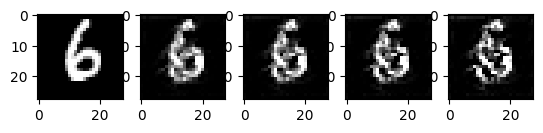

overshoot: 0.95 | maxIter: 15
overshoot: 1.50 | maxIter: 10
overshoot: 2.25 | maxIter: 7
overshoot: 3.00 | maxIter: 5


In [ ]:
figure, axis = plt.subplots(1, 5)
axis[0].imshow(origImg, cmap='gray', vmin=0, vmax=255)
axis[1].imshow(MNIST_10_DF[265]["adv"], cmap='gray', vmin=0, vmax=255)
axis[2].imshow(MNIST_10_DF[365]["adv"], cmap='gray', vmin=0, vmax=255)
axis[3].imshow(MNIST_10_DF[465]["adv"], cmap='gray', vmin=0, vmax=255)
axis[4].imshow(MNIST_10_DF[665]["adv"], cmap='gray', vmin=0, vmax=255)

plt.show()

print(MNIST_10_DF[200]["info"])
print(MNIST_10_DF[300]["info"])
print(MNIST_10_DF[400]["info"])
print(MNIST_10_DF[500]["info"])

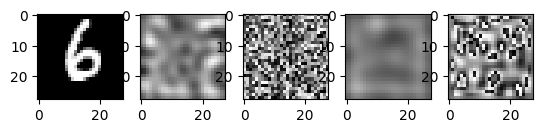

overshoot: -1.70 | maxIter: 12
overshoot: -3.00 | maxIter: 15
overshoot: -5.00 | maxIter: 10
overshoot: 0.00 | maxIter: 0


In [ ]:
figure, axis = plt.subplots(1, 5)
axis[0].imshow(origImg, cmap='gray', vmin=0, vmax=255)
axis[1].imshow(MNIST_10_NOISE[265]["adv"], cmap='gray', vmin=0, vmax=255)
axis[2].imshow(MNIST_10_NOISE[365]["adv"], cmap='gray', vmin=0, vmax=255)
axis[3].imshow(MNIST_10_NOISE[465]["adv"], cmap='gray', vmin=0, vmax=255)
axis[4].imshow(MNIST_10_NOISE[665]["adv"], cmap='gray', vmin=0, vmax=255)

plt.show()

print(MNIST_10_NOISE[200]["info"])
print(MNIST_10_NOISE[300]["info"])
print(MNIST_10_NOISE[400]["info"])
print(MNIST_10_NOISE[500]["info"])

In [ ]:
scaling = 4
path = "/content/drive/MyDrive/Colab Notebooks/temp_images"
title = "MNIST_6.5"

png = Image.fromarray(preparePicture(origImg, scaling))
png.save("%s/%s_orig.png" % (path, title))

png = Image.fromarray(preparePicture(MNIST_10_FGSM[265]["adv"], scaling))
png.save("%s/%s_FGSM_0.1.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_FGSM[465]["adv"], scaling))
png.save("%s/%s_FGSM_0.25.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_FGSM[665]["adv"], scaling))
png.save("%s/%s_FGSM_0.35.png" % (path, title))

png = Image.fromarray(preparePicture(MNIST_10_CW[365]["adv"], scaling))
png.save("%s/%s_CW_1.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_CW[465]["adv"], scaling))
png.save("%s/%s_CW_2.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_CW[665]["adv"], scaling))
png.save("%s/%s_CW_3.png" % (path, title))

png = Image.fromarray(preparePicture(MNIST_10_DF[265]["adv"], scaling))
png.save("%s/%s_DF_1.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_DF[365]["adv"], scaling))
png.save("%s/%s_DF_2.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_DF[665]["adv"], scaling))
png.save("%s/%s_DF_3.png" % (path, title))

png = Image.fromarray(preparePicture(MNIST_10_NOISE[265]["adv"], scaling))
png.save("%s/%s_UI_1.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_NOISE[365]["adv"], scaling))
png.save("%s/%s_UI_2.png" % (path, title))
png = Image.fromarray(preparePicture(MNIST_10_NOISE[665]["adv"], scaling))
png.save("%s/%s_UI_3.png" % (path, title))

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/temp_images"
for i in range(0, 100):
  cifra = int(i / 10)
  counter = i % 10
  png = Image.fromarray(preparePicture(MNIST_10_CW[i + random.choice([1, 2, 3, 4, 5, 6]) * 100]["adv"], 2))
  png.save("%s/%d.%d_CW_%d.png" % (path, cifra, counter, i))

[  498.         43482.          2330.86164326   255.        ] [  518.         38810.          2027.59068848   253.        ] [  504.         37680.          2024.29642098   253.        ]


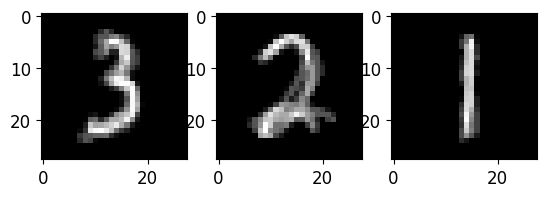

In [ ]:
advImage = MNIST_10_FGSM[300 + indx]["adv"]
numTemplates = 3
numSamples = int(len(digitData) / 10) # кол-во примеров на каждый класс цифры
digitsMetrics = np.zeros((numSamples * 10, 5))
cifrasAvrgMetrics = np.zeros((10, 5))

for i in range(numSamples * 10):
  L0, L1, L2, Linf = Metrics(digitData[i], advImage)
  digitsMetrics[i][:] = [i, L0, L1, L2, Linf]
  cifrasAvrgMetrics[digitLabels[i]][:] += [digitLabels[i], L0, L1, L2, Linf]
cifrasAvrgMetrics = cifrasAvrgMetrics / numSamples
sortIndx_1 = cifrasAvrgMetrics[np.lexsort((cifrasAvrgMetrics[:, 4],
                                            cifrasAvrgMetrics[:, 1],
                                            cifrasAvrgMetrics[:, 2],
                                            cifrasAvrgMetrics[:, 3]))]
searchCifras = []
searchData = []
extrNumber = 3
for i in range(0, extrNumber):
  searchCifras.append(int(sortIndx_1[i][0]))
  searchData.extend(digitsMetrics[numSamples*int(sortIndx_1[i][0]) : numSamples*(int(sortIndx_1[i][0]) + 1)])
searchData = np.array(searchData)
sortIndx_2 = np.lexsort((searchData[:, 4],
                          searchData[:, 3],
                          searchData[:, 2],
                          searchData[:, 1]))
# orig = digitData[int(searchData[ind][0][0])]
tempOrigs = np.zeros((len(searchCifras), 28, 28))
tempOrigsMetrics = np.zeros((len(searchCifras), 4))

lol = []
for i in range(0, len(searchCifras)):
  counter = 0
  for j in range(0, len(searchData)):
    if digitLabels[int(searchData[sortIndx_2][j][0])] == searchCifras[i]:
      tempOrigs[i] += digitData[int(searchData[sortIndx_2][j][0])]
      lol.append(digitData[int(searchData[sortIndx_2][j][0])])
      counter += 1
    if counter == numTemplates:
      tempOrigs[i] = (tempOrigs[i] / numTemplates).astype(np.uint8)
      L0, L1, L2, Linf = Metrics(tempOrigs[i], advImage)
      tempOrigsMetrics[i] = [L0, L1, L2, Linf]
      break
sortIndx = np.lexsort((tempOrigsMetrics[:, 3],
                        tempOrigsMetrics[:, 0],
                        tempOrigsMetrics[:, 1],
                        tempOrigsMetrics[:, 2]))
# sortIndx[0] - предполагаемый класс цифры
# return getDifferenceFromImages(advImg, tempOrigs[ttt[0]], True)

figure, axis = plt.subplots(1, 3)
axis[0].imshow(tempOrigs[sortIndx[0]], cmap='gray', vmin=0, vmax=255)
axis[1].imshow(tempOrigs[sortIndx[1]], cmap='gray', vmin=0, vmax=255)
axis[2].imshow(tempOrigs[sortIndx[2]], cmap='gray', vmin=0, vmax=255)

print(tempOrigsMetrics[sortIndx[0]], tempOrigsMetrics[sortIndx[1]], tempOrigsMetrics[sortIndx[2]])

In [ ]:
png = Image.fromarray(preparePicture(tempOrigs[sortIndx[0]], 4))
png.save("%s/tempOrig_1.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))
png = Image.fromarray(preparePicture(tempOrigs[sortIndx[1]], 4))
png.save("%s/tempOrig_2.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))
png = Image.fromarray(preparePicture(tempOrigs[sortIndx[2]], 4))
png.save("%s/tempOrig_3.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images"))

In [ ]:
for i in range(0, len(lol)):
  png = Image.fromarray(preparePicture(lol[i], 2))
  png.save("%s/%d.png" % ("/content/drive/MyDrive/Colab Notebooks/temp_images", i))